<div style="font-family:monospace; font-size:15px; line-height:1.5; border-top: 1px solid black; border-bottom: 1px solid black; padding: 10px; text-align: center;">
    <strong>ADAM-SINDy OPTIMIZATION - DYNAMICAL SYSTEM IDENTIFICATION</strong><br>
    <strong></strong> SIVA VIKNESH, YOUNES TATARI<br>
    <strong></strong> siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com<br>
    <strong></strong> SCIENTIFIC COMPUTING & IMAGING INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA<br>
</div>


In [1]:
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import integrate

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]


Combustion:  <br>
Paper: Symbolic regression via neural networks :
\
Chemical kinetics with Arrhenius rate dependence


$$
\dot{\alpha} = -k \alpha  e^{\theta} + \mu
$$

$$
\dot{\theta} = \alpha e^{\theta} - \theta
$$

Parameters: \\(k\\), \\(\mu\\)

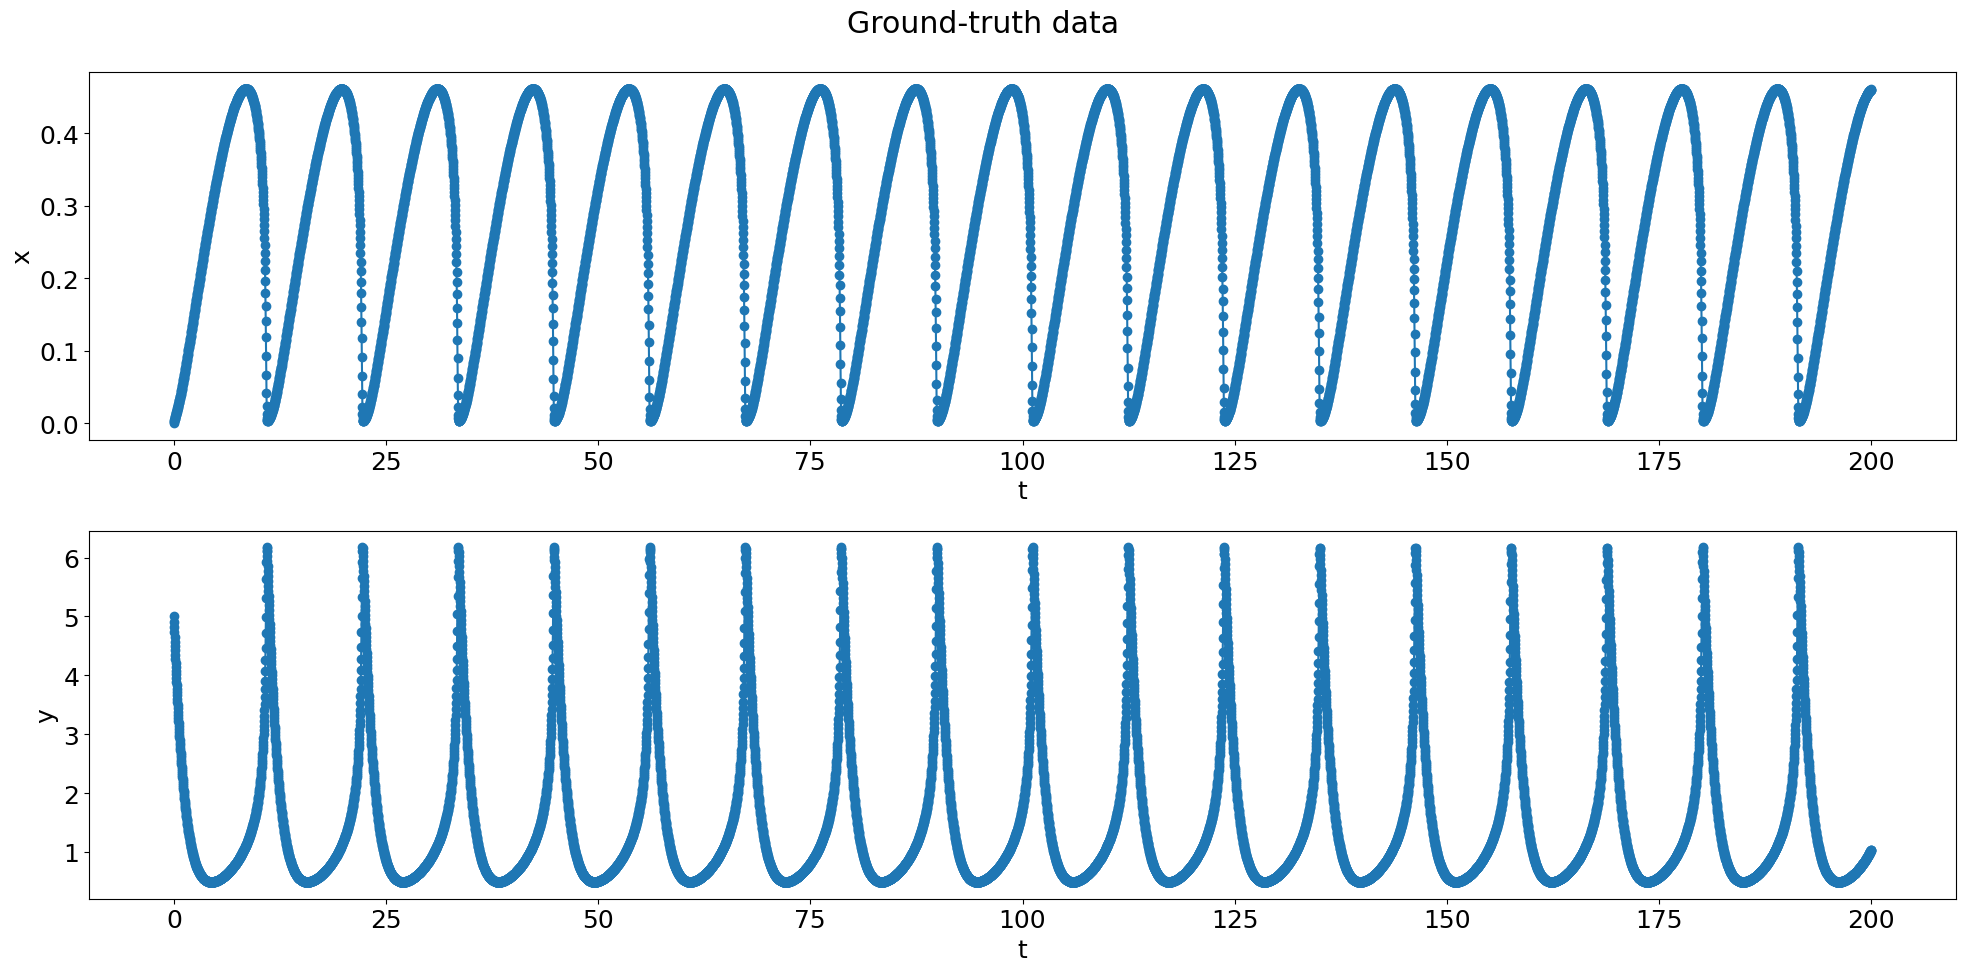

In [2]:
k  = 0.07
mu = 0.1
a  = 1.015
b  = 1.025

def oscillator_deriv(x_y, t0, a =a, b =b,  k=k, mu =mu):
    x, y = x_y
    dxdt = -k*x*np.exp(a*y) + mu
    dydt = x*np.exp(b*y) - y
    return [dxdt, dydt]

np.random.seed(123)
x0 = (0.0,5.0)

# Time points
t = np.linspace(0, 200, 10000)

x_t = integrate.odeint(oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x, y = x_t.T

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data')

ax[0].plot(t, x, '-o')
#ax[0].set_title('$x$')
ax[0].set(xlabel="t",ylabel="x")

ax[1].plot(t, y, '-o')
#ax[1].set_title('$y$')
ax[1].set(xlabel="t",ylabel="y")

fig.tight_layout()
plt.show()

In [3]:
# COMPUTING THE COMBINATIONS AMONG THE THREE CHOSEN TEMPORAL MODES

def POOL_DATA(yin, nVars, polyorder):
    n = yin.shape[0]
    yout = torch.zeros((n, 1)).to(processor)

    # poly order 0
    yout[:, 0] = torch.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = torch.cat((yout, yin[:, i].reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i, nVars):
                yout = torch.cat((yout, (yin[:, i] * yin[:, j]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    yout = torch.cat((yout, (yin[:, i] * yin[:, j] * yin[:, k]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    return yout

def DERIVATIVE(x, y, k, a, b, mu):
    dxdt = -k*torch.mul(x,torch.exp(a*y)) + mu
    dydt = torch.mul(x, torch.exp(b*y)) - y
    return torch.vstack((dxdt, dydt)).T


AVAILABLE PROCESSOR: cuda 



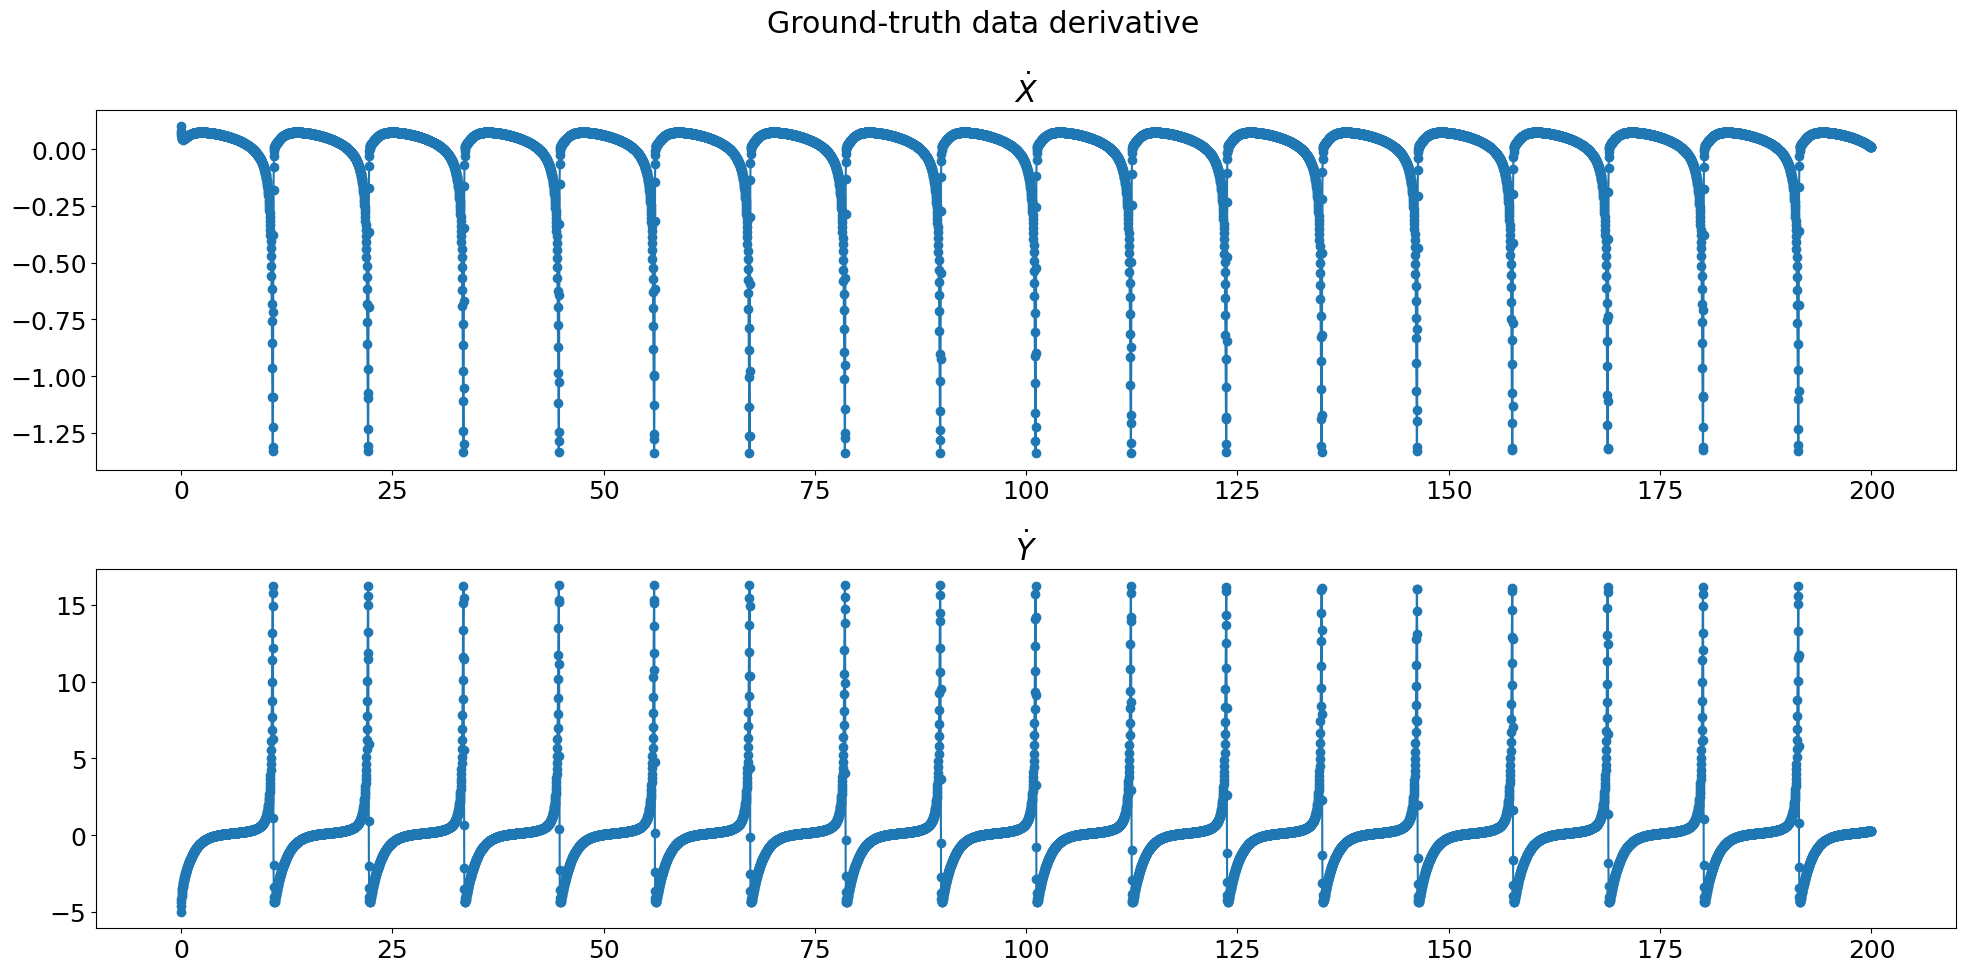

In [4]:
processor = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("AVAILABLE PROCESSOR:", processor, '\n')


N_modes  = 2
x_t      = torch.Tensor(x_t).to(processor)
x        = torch.Tensor(x).to(processor)
y        = torch.Tensor(y).to(processor)
t        = torch.Tensor(t).to(processor)

A_candidates = POOL_DATA (x_t, 2, 1).to(processor)
A1A2_time_deriv = DERIVATIVE (x, y, k, a, b, mu).to(processor)

# HYPERPARAMETERS FOR THE SINDy POD METHODOLOGY
Epochs        = 20000
learning_rate = 1e-2
step_epoch    = 3000
decay_rate    = 0.50
tolerance     = 5e-3

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data derivative')

ax[0].plot(t.detach().cpu().numpy(), A1A2_time_deriv[:, 0].detach().cpu().numpy(), '-o')
ax[0].set_title(r"$\dot{X}$")

ax[1].plot(t.detach().cpu().numpy(), A1A2_time_deriv[:, 1].detach().cpu().numpy(), '-o')
ax[1].set_title(r"$\dot{Y}$")

fig.tight_layout()
plt.show()

In [5]:
class SINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.sin(self.b*x)
        return output

class COSINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.cos(self.b*x)
        return output

class POWER_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.sign(x) * torch.pow(torch.abs(x), self.b)
        return output

class EXP_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.exp(self.b*x)
        return output

In [6]:
class ADAM_SINDy_MODEL(nn.Module):
    def __init__(self, a, asine, acosine, aexp, axsine, axcosine, axexp):
        super().__init__()    
        self.a        = a
        self.asine    = asine
        self.acosine  = acosine
        self.aexp     = aexp
        self.axsine   = axsine
        self.axcosine = axcosine
        self.axexp    = axexp
        
        self.sine     = SINE_TERM   (self.asine)
        self.cosine   = COSINE_TERM (self.acosine)
        self.exp      = EXP_TERM    (self.aexp)
        self.xsine    = SINE_TERM   (self.axsine)
        self.xcosine  = COSINE_TERM (self.axcosine)
        self.xexp     = EXP_TERM    (self.axexp)
        
    def forward(self, x):
        x1             = x [:, 1:]
        output_sine    = self.sine   (x1)
        output_cosine  = self.cosine (x1)
        output_exp     = self.exp    (x1)

        output_xsine   = self.xsine   (x1)
        output_xcosine = self.xcosine (x1)
        output_xexp    = self.xexp    (x1)
 
        output_xsine   = (output_xsine  [:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_xcosine = (output_xcosine[:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_xexp    = (output_xexp   [:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        
        output = torch.hstack((x, output_sine, output_cosine, output_exp, output_xsine, output_xcosine, output_xexp)) @ self.a
        return output


In [7]:
# AMPLITUDE COEFFICIENTS OF SINDy MODEL
COEFF_ADT   = torch.ones(21, N_modes, requires_grad= True, device= processor)

SINE_ADT    = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)
COSINE_ADT  = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)

XSINE_ADT   = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)
XCOSINE_ADT = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)

EXP_ADT     = torch.full((A_candidates.shape[1]-1, N_modes), 1.0, requires_grad= True, device= processor)
XEXP_ADT    = torch.full((A_candidates.shape[1]-1, N_modes), 1.0, requires_grad= True, device= processor)

In [8]:
# COEFFICIENTS OF SINDy MODEL
optim_COEFF_ADT = optim.Adam([COEFF_ADT, EXP_ADT, XEXP_ADT], lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

# WEIGHT FUNCTION OF SINDy MODEL
WEIGHTS     = Parameter(torch.ones_like(COEFF_ADT), requires_grad= True)
nn.init.normal_(WEIGHTS, mean=0, std=1)
Lambda      = Parameter(torch.tensor(1e-12), requires_grad= True)

optim_weights = optim.Adam([WEIGHTS], lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_Lambda  = optim.Adam([Lambda],  lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)


# STEP DECAY DYNAMIC LEARNING RATE
scheduler_ADT     = torch.optim.lr_scheduler.StepLR(optim_COEFF_ADT, step_size=step_epoch, gamma=decay_rate)
scheduler_weights = torch.optim.lr_scheduler.StepLR(optim_weights,   step_size=step_epoch, gamma=decay_rate)
scheduler_LAMBDA  = torch.optim.lr_scheduler.StepLR(optim_Lambda,    step_size=step_epoch, gamma=decay_rate)

**Adaptive SINDy training**

In [9]:
# TEMPORAL MODE 1
A1_DT = ADAM_SINDy_MODEL(COEFF_ADT [:, 0], SINE_ADT [:, 0], COSINE_ADT[:, 0], EXP_ADT[:, 0], XSINE_ADT [:, 0], XCOSINE_ADT[:, 0], XEXP_ADT [:, 0]).to(processor)

# TEMPORAL MODE 2
A2_DT = ADAM_SINDy_MODEL(COEFF_ADT [:, 1], SINE_ADT [:, 1], COSINE_ADT[:, 1], EXP_ADT[:, 1], XSINE_ADT [:, 1], XCOSINE_ADT[:, 1], XEXP_ADT [:, 1]).to(processor)

Loss_data        = torch.empty(size=(Epochs, 1))
Lambda_min       = torch.empty(size=(Epochs, 1))
loss_function    = nn.MSELoss()

for epoch in range(Epochs):
    A1_out, A2_out  = A1_DT(A_candidates), A2_DT(A_candidates)
    output_data     = torch.stack((A1_out, A2_out), dim=1)
    loss_epoch      = loss_function(A1A2_time_deriv, output_data) + (torch.abs(Lambda)) * torch.linalg.matrix_norm(COEFF_ADT, ord=1)
    
    optim_COEFF_ADT.zero_grad()
    optim_Lambda.zero_grad()
    optim_weights.zero_grad()
    
    loss_epoch.backward()

    with torch.no_grad():
        optim_COEFF_ADT.step()
        optim_Lambda.step()        
        optim_weights.step()
        
        Loss_data       [epoch]  = loss_epoch.detach()
        Lambda_min      [epoch]  = Lambda.detach()
        
        COEFF_ADT   [torch.abs(COEFF_ADT)   <= tolerance] = 0.0
        SINE_ADT    [torch.abs(SINE_ADT)    <= tolerance] = 0.0
        COSINE_ADT  [torch.abs(COSINE_ADT)  <= tolerance] = 0.0
        XSINE_ADT   [torch.abs(XSINE_ADT)   <= tolerance] = 0.0
        XCOSINE_ADT [torch.abs(XCOSINE_ADT) <= tolerance] = 0.0
        EXP_ADT     [torch.abs(EXP_ADT)     <= tolerance] = 0.0
        XEXP_ADT    [torch.abs(XEXP_ADT)    <= tolerance] = 0.0
        Lambda      [torch.abs(Lambda)      <= 0.0      ] = tolerance
       

    print('LOSS DATA, [EPOCH =', epoch, ']:', Loss_data[epoch].item())
    print('LEARNING RATE:', optim_COEFF_ADT.param_groups[0]['lr'])
    print('*' * 85)    
    
    # Scheduler steps
    scheduler_ADT.step()
    scheduler_LAMBDA.step()
    scheduler_weights.step()


LOSS DATA, [EPOCH = 0 ]: 186351.296875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1 ]: 162819.171875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2 ]: 142359.46875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3 ]: 124618.1015625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4 ]: 109265.734375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 5 ]: 96000.5625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 6 ]: 84549.0703125
LEARNING RATE: 0.01
**************************************************************************

LOSS DATA, [EPOCH = 72 ]: 3460.515869140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 73 ]: 3402.93798828125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 74 ]: 3346.8876953125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 75 ]: 3292.292724609375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 76 ]: 3239.11083984375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 77 ]: 3187.257080078125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 78 ]: 3136.670654296875
LEARNING RATE: 0.01
****************************************

LOSS DATA, [EPOCH = 129 ]: 1541.578857421875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 130 ]: 1522.1651611328125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 131 ]: 1503.0443115234375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 132 ]: 1484.203369140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 133 ]: 1465.6407470703125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 134 ]: 1447.362548828125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 135 ]: 1429.3580322265625
LEARNING RATE: 0.01
*************************

LOSS DATA, [EPOCH = 194 ]: 730.1731567382812
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 195 ]: 723.10546875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 196 ]: 716.11083984375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 197 ]: 709.193115234375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 198 ]: 702.3648681640625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 199 ]: 695.6185302734375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 200 ]: 688.9697875976562
LEARNING RATE: 0.01
*************************************

LOSS DATA, [EPOCH = 275 ]: 350.0028381347656
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 276 ]: 346.9859619140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 277 ]: 344.0055236816406
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 278 ]: 341.05108642578125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 279 ]: 338.109375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 280 ]: 335.2347717285156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 281 ]: 332.3697509765625
LEARNING RATE: 0.01
***********************************

LOSS DATA, [EPOCH = 348 ]: 189.0574951171875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 349 ]: 187.51702880859375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 350 ]: 185.97096252441406
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 351 ]: 184.4386444091797
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 352 ]: 182.92787170410156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 353 ]: 181.41964721679688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 354 ]: 179.92881774902344
LEARNING RATE: 0.01
************************

LOSS DATA, [EPOCH = 419 ]: 106.40214538574219
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 420 ]: 105.59909057617188
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 421 ]: 104.7797622680664
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 422 ]: 103.94600677490234
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 423 ]: 103.09981536865234
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 424 ]: 102.3133316040039
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 425 ]: 101.53093719482422
LEARNING RATE: 0.01
************************

LOSS DATA, [EPOCH = 485 ]: 64.10389709472656
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 486 ]: 63.62955093383789
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 487 ]: 63.13774871826172
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 488 ]: 62.645328521728516
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 489 ]: 62.20124053955078
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 490 ]: 61.73777770996094
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 491 ]: 61.2791862487793
LEARNING RATE: 0.01
*****************************

LOSS DATA, [EPOCH = 547 ]: 41.380435943603516
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 548 ]: 41.078487396240234
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 549 ]: 40.823307037353516
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 550 ]: 40.54721450805664
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 551 ]: 40.27446365356445
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 552 ]: 40.01325988769531
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 553 ]: 39.74088668823242
LEARNING RATE: 0.01
**************************

LOSS DATA, [EPOCH = 609 ]: 28.155197143554688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 610 ]: 27.986976623535156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 611 ]: 27.82127571105957
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 612 ]: 27.665287017822266
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 613 ]: 27.497539520263672
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 614 ]: 27.337810516357422
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 615 ]: 27.19704246520996
LEARNING RATE: 0.01
************************

LOSS DATA, [EPOCH = 671 ]: 20.10492515563965
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 672 ]: 20.004554748535156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 673 ]: 19.89293098449707
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 674 ]: 19.788442611694336
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 675 ]: 19.70008087158203
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 676 ]: 19.59427261352539
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 677 ]: 19.499839782714844
LEARNING RATE: 0.01
**************************

LOSS DATA, [EPOCH = 733 ]: 14.538029670715332
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 734 ]: 14.453263282775879
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 735 ]: 14.381815910339355
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 736 ]: 14.295548439025879
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 737 ]: 14.219164848327637
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 738 ]: 14.140236854553223
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 739 ]: 14.046104431152344
LEARNING RATE: 0.01
**********************

LOSS DATA, [EPOCH = 795 ]: 9.818649291992188
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 796 ]: 9.748039245605469
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 797 ]: 9.687707901000977
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 798 ]: 9.624116897583008
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 799 ]: 9.54566764831543
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 800 ]: 9.506258964538574
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 801 ]: 9.451224327087402
LEARNING RATE: 0.01
******************************

LOSS DATA, [EPOCH = 857 ]: 6.406786918640137
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 858 ]: 6.364910125732422
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 859 ]: 6.304352760314941
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 860 ]: 6.292034149169922
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 861 ]: 6.2602949142456055
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 862 ]: 6.209408760070801
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 863 ]: 6.140124320983887
LEARNING RATE: 0.01
****************************

LOSS DATA, [EPOCH = 919 ]: 4.2049055099487305
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 920 ]: 4.217066287994385
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 921 ]: 4.2045111656188965
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 922 ]: 4.168110370635986
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 923 ]: 4.110113620758057
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 924 ]: 4.112635135650635
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 925 ]: 4.110823154449463
LEARNING RATE: 0.01
***************************

LOSS DATA, [EPOCH = 981 ]: 3.0198659896850586
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 982 ]: 2.9939591884613037
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 983 ]: 2.9431605339050293
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 984 ]: 2.960608720779419
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 985 ]: 2.9739692211151123
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 986 ]: 2.9584925174713135
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 987 ]: 2.9170024394989014
LEARNING RATE: 0.01
***********************

LOSS DATA, [EPOCH = 1043 ]: 2.3112916946411133
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1044 ]: 2.336329221725464
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1045 ]: 2.357227087020874
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1046 ]: 2.347775459289551
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1047 ]: 2.3110010623931885
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1048 ]: 2.267700672149658
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1049 ]: 2.2813024520874023
LEARNING RATE: 0.01
*******************

LOSS DATA, [EPOCH = 1106 ]: 1.9896973371505737
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1107 ]: 1.9558711051940918
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1108 ]: 1.9152774810791016
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1109 ]: 1.9313613176345825
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1110 ]: 1.9180389642715454
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1111 ]: 1.9065349102020264
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1112 ]: 1.9061628580093384
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 1170 ]: 1.6641215085983276
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1171 ]: 1.6532304286956787
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1172 ]: 1.6535183191299438
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1173 ]: 1.6367928981781006
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1174 ]: 1.6286885738372803
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1175 ]: 1.6443564891815186
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1176 ]: 1.6328449249267578
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 1233 ]: 1.4060866832733154
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1234 ]: 1.3981457948684692
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1235 ]: 1.4141865968704224
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1236 ]: 1.4028164148330688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1237 ]: 1.407266616821289
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1238 ]: 1.4071179628372192
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1239 ]: 1.3794704675674438
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1294 ]: 1.1879912614822388
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1295 ]: 1.204274296760559
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1296 ]: 1.1933244466781616
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1297 ]: 1.1981229782104492
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1298 ]: 1.1983332633972168
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1299 ]: 1.171209692955017
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1300 ]: 1.215110182762146
LEARNING RATE: 0.01
******************

LOSS DATA, [EPOCH = 1380 ]: 0.9770603775978088
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1381 ]: 0.9907243251800537
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1382 ]: 0.9763044714927673
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1383 ]: 0.9366841316223145
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1384 ]: 0.9652884602546692
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1385 ]: 0.9900752305984497
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1386 ]: 0.9857233762741089
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 1447 ]: 0.8162593245506287
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1448 ]: 0.779421865940094
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1449 ]: 0.7977782487869263
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1450 ]: 0.7872087359428406
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1451 ]: 0.7780060768127441
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1452 ]: 0.7801442742347717
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1453 ]: 0.7654219269752502
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1518 ]: 0.6677166819572449
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1519 ]: 0.6411487460136414
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1520 ]: 0.689685583114624
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1521 ]: 0.7055091857910156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1522 ]: 0.6912595629692078
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1523 ]: 0.6498535871505737
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1524 ]: 0.6817097663879395
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1602 ]: 0.5392401814460754
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1603 ]: 0.5470196604728699
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1604 ]: 0.5497965216636658
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1605 ]: 0.5191724896430969
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1606 ]: 0.5768318176269531
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1607 ]: 0.5959247350692749
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1608 ]: 0.5797780156135559
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 1670 ]: 0.4657811224460602
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1671 ]: 0.4323011636734009
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1672 ]: 0.43838369846343994
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1673 ]: 0.4523407518863678
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1674 ]: 0.44133260846138
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1675 ]: 0.4601755142211914
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1676 ]: 0.4631405472755432
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1732 ]: 0.36997297406196594
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1733 ]: 0.3984648585319519
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1734 ]: 0.3851695954799652
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1735 ]: 0.37453728914260864
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1736 ]: 0.3792867064476013
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1737 ]: 0.3594655692577362
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1738 ]: 0.3520871698856354
LEARNING RATE: 0.01
*************

LOSS DATA, [EPOCH = 1809 ]: 0.2718886137008667
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1810 ]: 0.3408859968185425
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1811 ]: 0.36404597759246826
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1812 ]: 0.34550565481185913
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1813 ]: 0.28941619396209717
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1814 ]: 0.3336580991744995
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1815 ]: 0.37335970997810364
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 1903 ]: 0.19571885466575623
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1904 ]: 0.18714244663715363
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1905 ]: 0.2158985435962677
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1906 ]: 0.20417800545692444
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1907 ]: 0.21294823288917542
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1908 ]: 0.21703964471817017
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1909 ]: 0.1824485957622528
LEARNING RATE: 0.01
**********

LOSS DATA, [EPOCH = 1989 ]: 0.1825128197669983
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1990 ]: 0.1354142427444458
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1991 ]: 0.1628398299217224
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1992 ]: 0.150614395737648
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1993 ]: 0.13851244747638702
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1994 ]: 0.1435837745666504
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1995 ]: 0.12727589905261993
LEARNING RATE: 0.01
**************

LOSS DATA, [EPOCH = 2049 ]: 0.1140352115035057
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2050 ]: 0.10469572991132736
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2051 ]: 0.12269993871450424
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2052 ]: 0.12639838457107544
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2053 ]: 0.09461487829685211
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2054 ]: 0.15004940330982208
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2055 ]: 0.17121171951293945
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 2118 ]: 0.09313291311264038
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2119 ]: 0.07803314179182053
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2120 ]: 0.0718112587928772
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2121 ]: 0.09623847901821136
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2122 ]: 0.0868934839963913
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2123 ]: 0.09483238309621811
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2124 ]: 0.09871871769428253
LEARNING RATE: 0.01
**********

LOSS DATA, [EPOCH = 2179 ]: 0.07741308212280273
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2180 ]: 0.06922239810228348
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2181 ]: 0.08477228134870529
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2182 ]: 0.0880688726902008
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2183 ]: 0.06111476942896843
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2184 ]: 0.10875454545021057
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2185 ]: 0.12716180086135864
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 2258 ]: 0.2728238105773926
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2259 ]: 0.07091715186834335
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2260 ]: 0.21182584762573242
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2261 ]: 0.051513850688934326
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2262 ]: 0.09296908974647522
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2263 ]: 0.10781599581241608
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2264 ]: 0.09608862549066544
LEARNING RATE: 0.01
********

LOSS DATA, [EPOCH = 2346 ]: 0.044856809079647064
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2347 ]: 0.06299366056919098
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2348 ]: 0.055374227464199066
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2349 ]: 0.04686141014099121
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2350 ]: 0.0504293330013752
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2351 ]: 0.04124131798744202
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2352 ]: 0.03577809035778046
LEARNING RATE: 0.01
*******

LOSS DATA, [EPOCH = 2426 ]: 0.04014546051621437
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2427 ]: 0.03221047297120094
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2428 ]: 0.027340523898601532
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2429 ]: 0.05172355845570564
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2430 ]: 0.053343214094638824
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2431 ]: 0.0337086021900177
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2432 ]: 0.05787287652492523
LEARNING RATE: 0.01
*******

LOSS DATA, [EPOCH = 2511 ]: 0.0383433923125267
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2512 ]: 0.032620709389448166
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2513 ]: 0.026545662432909012
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2514 ]: 0.02916795387864113
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2515 ]: 0.022034451365470886
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2516 ]: 0.017955215647816658
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2517 ]: 0.03881775215268135
LEARNING RATE: 0.01
*****

LOSS DATA, [EPOCH = 2590 ]: 0.03753235563635826
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2591 ]: 0.04688910022377968
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2592 ]: 0.040283165872097015
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2593 ]: 0.019389163702726364
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2594 ]: 0.036215923726558685
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2595 ]: 0.05141644924879074
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2596 ]: 0.05020763725042343
LEARNING RATE: 0.01
*****

LOSS DATA, [EPOCH = 2663 ]: 0.020526617765426636
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2664 ]: 0.02233080379664898
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2665 ]: 0.009871450252830982
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2666 ]: 0.012006975710391998
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2667 ]: 0.019044596701860428
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2668 ]: 0.015089355409145355
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2669 ]: 0.02200370281934738
LEARNING RATE: 0.01
***

LOSS DATA, [EPOCH = 2734 ]: 0.029912464320659637
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2735 ]: 0.039367567747831345
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2736 ]: 0.03332065790891647
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2737 ]: 0.01334819383919239
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2738 ]: 0.034428637474775314
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2739 ]: 0.04908022657036781
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2740 ]: 0.04774829000234604
LEARNING RATE: 0.01
*****

LOSS DATA, [EPOCH = 2820 ]: 0.021958667784929276
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2821 ]: 0.009599383920431137
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2822 ]: 0.025867175310850143
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2823 ]: 0.03448798134922981
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2824 ]: 0.02897031232714653
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2825 ]: 0.010768469423055649
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2826 ]: 0.029693523421883583
LEARNING RATE: 0.01
***

LOSS DATA, [EPOCH = 2899 ]: 0.017937054857611656
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2900 ]: 0.018816260620951653
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2901 ]: 0.00760736595839262
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2902 ]: 0.021680328994989395
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2903 ]: 0.02949180081486702
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2904 ]: 0.024553053081035614
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2905 ]: 0.008175179362297058
LEARNING RATE: 0.01
***

LOSS DATA, [EPOCH = 2974 ]: 0.01797894760966301
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2975 ]: 0.024796441197395325
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2976 ]: 0.02050815522670746
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2977 ]: 0.006268615368753672
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2978 ]: 0.02112666331231594
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2979 ]: 0.03154899552464485
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2980 ]: 0.030578045174479485
LEARNING RATE: 0.01
*****

LOSS DATA, [EPOCH = 3039 ]: 0.002511249389499426
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3040 ]: 0.003204495180398226
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3041 ]: 0.004174772184342146
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3042 ]: 0.003116681706160307
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3043 ]: 0.005816341377794743
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3044 ]: 0.006176905706524849
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3045 ]: 0.0016331542283296585
LEARNING RATE:

LOSS DATA, [EPOCH = 3119 ]: 0.012628967873752117
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3120 ]: 0.010720333084464073
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3121 ]: 0.004375654738396406
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3122 ]: 0.00825710128992796
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3123 ]: 0.012912767939269543
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3124 ]: 0.012489024549722672
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3125 ]: 0.0074964058585464954
LEARNING RATE: 

LOSS DATA, [EPOCH = 3198 ]: 0.003539099358022213
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3199 ]: 0.0069367410615086555
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3200 ]: 0.005620904266834259
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3201 ]: 0.0018201672937721014
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3202 ]: 0.0024447545874863863
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3203 ]: 0.0032361182384192944
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3204 ]: 0.002291664946824312
LEARNING RA

LOSS DATA, [EPOCH = 3272 ]: 0.005184093024581671
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3273 ]: 0.001569306361488998
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3274 ]: 0.0021475856192409992
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3275 ]: 0.0029581517446786165
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3276 ]: 0.0020747296512126923
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3277 ]: 0.004316325765103102
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3278 ]: 0.004616987891495228
LEARNING RAT

LOSS DATA, [EPOCH = 3331 ]: 0.003971691243350506
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3332 ]: 0.004254862666130066
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3333 ]: 0.0007263837032951415
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3334 ]: 0.007400220260024071
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3335 ]: 0.009868018329143524
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3336 ]: 0.008311382494866848
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3337 ]: 0.0031515327282249928
LEARNING RATE

LOSS DATA, [EPOCH = 3405 ]: 0.0009961508912965655
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3406 ]: 0.005878358148038387
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3407 ]: 0.008012069389224052
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3408 ]: 0.006671159528195858
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3409 ]: 0.0022171325981616974
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3410 ]: 0.005878040101379156
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3411 ]: 0.009141916409134865
LEARNING RATE

LOSS DATA, [EPOCH = 3489 ]: 0.0015055795665830374
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3490 ]: 0.0019174007466062903
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3491 ]: 0.0012774954084306955
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3492 ]: 0.000659748213365674
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3493 ]: 0.003443875815719366
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3494 ]: 0.00365586974658072
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3495 ]: 0.0010046918177977204
LEARNING RAT

LOSS DATA, [EPOCH = 3560 ]: 0.0023245657794177532
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3561 ]: 0.0014682079199701548
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3562 ]: 0.0018241617362946272
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3563 ]: 0.000951363705098629
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3564 ]: 0.0004151051689404994
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3565 ]: 0.0031425929628312588
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3566 ]: 0.0033245133236050606
LEARNING 

LOSS DATA, [EPOCH = 3617 ]: 0.00093430420383811
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3618 ]: 0.0004577817744575441
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3619 ]: 0.0027729952707886696
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3620 ]: 0.002947051078081131
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3621 ]: 0.0008547144243493676
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3622 ]: 0.00381771894171834
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3623 ]: 0.005297197960317135
LEARNING RATE:

LOSS DATA, [EPOCH = 3694 ]: 0.003599654883146286
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3695 ]: 0.0049676778726279736
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3696 ]: 0.004108568653464317
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3697 ]: 0.0012508732033893466
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3698 ]: 0.003863783087581396
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3699 ]: 0.005960434675216675
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3700 ]: 0.005767402704805136
LEARNING RATE

LOSS DATA, [EPOCH = 3756 ]: 0.0008630733354948461
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3757 ]: 0.002365784952417016
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3758 ]: 0.0018068146891891956
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3759 ]: 0.0010334495455026627
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3760 ]: 0.001296978909522295
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3761 ]: 0.0007987686549313366
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3762 ]: 0.0003963210037909448
LEARNING R

LOSS DATA, [EPOCH = 3820 ]: 0.0030278749763965607
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3821 ]: 0.004190349485725164
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3822 ]: 0.003454049350693822
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3823 ]: 0.0010654614306986332
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3824 ]: 0.0031921728514134884
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3825 ]: 0.004956502467393875
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3826 ]: 0.004791084676980972
LEARNING RAT

LOSS DATA, [EPOCH = 3890 ]: 0.0019272107165306807
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3891 ]: 0.0004535096522886306
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3892 ]: 0.00272804475389421
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3893 ]: 0.0037623196840286255
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3894 ]: 0.003121785121038556
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3895 ]: 0.0009647088591009378
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3896 ]: 0.0028145615942776203
LEARNING RA

LOSS DATA, [EPOCH = 3971 ]: 0.0022442627232521772
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3972 ]: 0.000704816950019449
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3973 ]: 0.0017462377436459064
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3974 ]: 0.0013438973110169172
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3975 ]: 0.0006254053441807628
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3976 ]: 0.0008161976002156734
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3977 ]: 0.0006133919814601541
LEARNING 

LOSS DATA, [EPOCH = 4046 ]: 0.0011425820412114263
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4047 ]: 0.0005378340138122439
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4048 ]: 0.0006993177812546492
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4049 ]: 0.0005101823480799794
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4050 ]: 0.0002596876001916826
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4051 ]: 0.0013099729549139738
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4052 ]: 0.0013926324900239706
LEARNING

LOSS DATA, [EPOCH = 4128 ]: 0.01280893012881279
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4129 ]: 0.010218269191682339
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4130 ]: 0.01120617426931858
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4131 ]: 0.011758821085095406
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4132 ]: 0.010703214444220066
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4133 ]: 0.008137937635183334
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4134 ]: 0.004885565023869276
LEARNING RATE: 0.

LOSS DATA, [EPOCH = 4200 ]: 0.0007365330820903182
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4201 ]: 0.0014042453840374947
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4202 ]: 0.0010466654784977436
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4203 ]: 0.001656520296819508
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4204 ]: 0.0018152944976463914
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4205 ]: 0.0007035922608338296
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4206 ]: 0.002661830047145486
LEARNING R

LOSS DATA, [EPOCH = 4283 ]: 0.0015034476527944207
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4284 ]: 0.0016603537369519472
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4285 ]: 0.0005738118197768927
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4286 ]: 0.002495342632755637
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4287 ]: 0.0032504538539797068
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4288 ]: 0.0027010866906493902
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4289 ]: 0.0009792096680030227
LEARNING 

LOSS DATA, [EPOCH = 4360 ]: 0.0005640484159812331
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4361 ]: 0.0010858697351068258
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4362 ]: 0.0007497268379665911
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4363 ]: 0.0014328277902677655
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4364 ]: 0.0015838434919714928
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4365 ]: 0.0005386949051171541
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4366 ]: 0.002276079962030053
LEARNING 

LOSS DATA, [EPOCH = 4426 ]: 0.0021772587206214666
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4427 ]: 0.00288418703712523
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4428 ]: 0.0023704632185399532
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4429 ]: 0.0007593627087771893
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4430 ]: 0.002410452114418149
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4431 ]: 0.003597155213356018
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4432 ]: 0.0035174600780010223
LEARNING RAT

LOSS DATA, [EPOCH = 4504 ]: 0.0013652670895680785
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4505 ]: 0.0003738577361218631
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4506 ]: 0.002078934805467725
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4507 ]: 0.002768615959212184
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4508 ]: 0.0022694836370646954
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4509 ]: 0.0007009069668129086
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4510 ]: 0.0022689199540764093
LEARNING R

LOSS DATA, [EPOCH = 4597 ]: 0.0008066241280175745
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4598 ]: 0.000975266913883388
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4599 ]: 0.00022980381618253887
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4600 ]: 0.0002841150271706283
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4601 ]: 0.0008477781666442752
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4602 ]: 0.0005391637096181512
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4603 ]: 0.0010869387770071626
LEARNING

LOSS DATA, [EPOCH = 4672 ]: 0.003002576297149062
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4673 ]: 0.0018898104317486286
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4674 ]: 0.0003124000213574618
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4675 ]: 0.001106630777940154
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4676 ]: 0.0007759626023471355
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4677 ]: 0.0007163815898820758
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4678 ]: 0.0008782881195656955
LEARNING R

LOSS DATA, [EPOCH = 4741 ]: 0.000726441154256463
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4742 ]: 0.0004338964936323464
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4743 ]: 0.0009321772959083319
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4744 ]: 0.0010652740020304918
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4745 ]: 0.00016540104115847498
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4746 ]: 0.0017369234701618552
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4747 ]: 0.002357433782890439
LEARNING 

LOSS DATA, [EPOCH = 4819 ]: 0.0007795011042617261
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4820 ]: 0.0009294296614825726
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4821 ]: 0.00012720681843347847
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4822 ]: 0.0015904165338724852
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4823 ]: 0.0021456407848745584
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4824 ]: 0.0017100393306463957
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4825 ]: 0.0003839705022983253
LEARNIN

LOSS DATA, [EPOCH = 4899 ]: 9.993246203521267e-05
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4900 ]: 0.0003291464236099273
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4901 ]: 0.0004798133159056306
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4902 ]: 0.00019963325757998973
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4903 ]: 0.0010807947255671024
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4904 ]: 0.0012208751868456602
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4905 ]: 0.00038453820161521435
LEARNI

LOSS DATA, [EPOCH = 4962 ]: 0.0014068246819078922
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4963 ]: 0.0019834914710372686
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4964 ]: 0.001538728945888579
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4965 ]: 0.00017980147094931453
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4966 ]: 0.0021004665177315474
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4967 ]: 0.0031077140010893345
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4968 ]: 0.003045910969376564
LEARNING 

LOSS DATA, [EPOCH = 5025 ]: 0.0020346834789961576
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5026 ]: 0.00010360804299125448
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5027 ]: 0.002672467613592744
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5028 ]: 0.0041398582980036736
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5029 ]: 0.004481973126530647
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5030 ]: 0.003811857895925641
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5031 ]: 0.0022357553243637085
LEARNING R

LOSS DATA, [EPOCH = 5102 ]: 0.003825822612270713
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5103 ]: 0.0022361883893609047
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5104 ]: 0.0002519155968911946
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5105 ]: 0.0014391756849363446
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5106 ]: 0.0015288167633116245
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5107 ]: 0.0006284726550802588
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5108 ]: 0.001235164818353951
LEARNING R

LOSS DATA, [EPOCH = 5186 ]: 0.0030322116799652576
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5187 ]: 0.001966410083696246
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5188 ]: 3.310888132546097e-05
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5189 ]: 0.0007982311653904617
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5190 ]: 0.0004989258013665676
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5191 ]: 0.0008199597941711545
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5192 ]: 0.0009658102644607425
LEARNING 

LOSS DATA, [EPOCH = 5259 ]: 0.0028843721374869347
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5260 ]: 0.002811746671795845
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5261 ]: 0.0017352139111608267
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5262 ]: 0.0002740217314567417
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5263 ]: 0.0010310469660907984
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5264 ]: 0.000732534215785563
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5265 ]: 0.0005912263877689838
LEARNING R

LOSS DATA, [EPOCH = 5343 ]: 0.0016835681162774563
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5344 ]: 0.0003474889090284705
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5345 ]: 0.0011279553873464465
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5346 ]: 0.0008294219151139259
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5347 ]: 0.0004901750944554806
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5348 ]: 0.0006316275103017688
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5349 ]: 0.00028253268101252615
LEARNIN

LOSS DATA, [EPOCH = 5410 ]: 0.0018046624027192593
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5411 ]: 0.00045152349048294127
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5412 ]: 0.0018109963275492191
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5413 ]: 0.0028140502981841564
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5414 ]: 0.0027262538205832243
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5415 ]: 0.0016544894315302372
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5416 ]: 0.00036370582529343665
LEARNI

LOSS DATA, [EPOCH = 5472 ]: 0.0008311158162541687
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5473 ]: 0.0004687361069954932
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5474 ]: 0.0006125238724052906
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5475 ]: 0.0002999662247020751
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5476 ]: 9.31124814087525e-05
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5477 ]: 0.0011706944787874818
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5478 ]: 0.0012553355190902948
LEARNING 

LOSS DATA, [EPOCH = 5546 ]: 0.0006026907358318567
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5547 ]: 0.0002980292774736881
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5548 ]: 8.520712435711175e-05
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5549 ]: 0.0011429211590439081
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5550 ]: 0.001222786377184093
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5551 ]: 0.00030231490381993353
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5552 ]: 0.0015858482802286744
LEARNING

LOSS DATA, [EPOCH = 5604 ]: 0.001210054149851203
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5605 ]: 0.0002866304712370038
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5606 ]: 0.0015832512872293591
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5607 ]: 0.0022382386960089207
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5608 ]: 0.001836239593103528
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5609 ]: 0.000480588962091133
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5610 ]: 0.0018047725316137075
LEARNING RA

LOSS DATA, [EPOCH = 5678 ]: 0.0015824324218556285
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5679 ]: 0.0022315136156976223
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5680 ]: 0.0018228533444926143
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5681 ]: 0.0004632277996279299
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5682 ]: 0.0017853443277999759
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5683 ]: 0.0027881658170372248
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5684 ]: 0.0026972973719239235
LEARNING

LOSS DATA, [EPOCH = 5750 ]: 0.0015939606819301844
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5751 ]: 0.00224294257350266
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5752 ]: 0.0018319543451070786
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5753 ]: 0.0004690879723057151
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5754 ]: 0.0017782559152692556
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5755 ]: 0.0027814609929919243
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5756 ]: 0.002692208159714937
LEARNING RA

LOSS DATA, [EPOCH = 5838 ]: 0.0011911161709576845
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5839 ]: 0.0002648319932632148
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5840 ]: 0.0015896190889179707
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5841 ]: 0.0022403812035918236
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5842 ]: 0.001832532580010593
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5843 ]: 0.0004722998128272593
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5844 ]: 0.001773592783138156
LEARNING R

LOSS DATA, [EPOCH = 5917 ]: 0.0026905934792011976
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5918 ]: 0.002589558018371463
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5919 ]: 0.001493484596721828
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5920 ]: 0.0005229362286627293
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5921 ]: 0.0012972333934158087
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5922 ]: 0.0010054567828774452
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5923 ]: 0.0002831971214618534
LEARNING R

LOSS DATA, [EPOCH = 5980 ]: 0.0003126816009171307
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5981 ]: 0.00090359355090186
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5982 ]: 0.0009796053636819124
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5983 ]: 5.253193012322299e-05
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5984 ]: 0.001800802769139409
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5985 ]: 0.002453715307638049
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5986 ]: 0.002046155044808984
LEARNING RATE

LOSS DATA, [EPOCH = 6047 ]: 0.0016241411212831736
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6048 ]: 0.001593036693520844
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6049 ]: 0.001067930250428617
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6050 ]: 9.834239608608186e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6051 ]: 0.0012944876216351986
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6052 ]: 0.0020300864707678556
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6053 ]: 0.002194985281676054
LEARN

LOSS DATA, [EPOCH = 6125 ]: 0.00023975387739483267
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6126 ]: 0.000670069654006511
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6127 ]: 0.0009718898218125105
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6128 ]: 0.0007461725035682321
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6129 ]: 4.556318890536204e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6130 ]: 0.0011043815175071359
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6131 ]: 0.0016220894176512957
LE

LOSS DATA, [EPOCH = 6191 ]: 0.0013012659037485719
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6192 ]: 0.0020373708102852106
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6193 ]: 0.002202757867053151
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6194 ]: 0.0018545876955613494
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6195 ]: 0.0010450163390487432
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6196 ]: 0.0002029456227319315
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6197 ]: 0.0008089106995612383
LEA

LOSS DATA, [EPOCH = 6260 ]: 0.00020190251234453171
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6261 ]: 0.0002062174753518775
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6262 ]: 5.768496703240089e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6263 ]: 0.0005936116212978959
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6264 ]: 0.0006639498751610518
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6265 ]: 0.00022982565860729665
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6266 ]: 0.0006783608696423471


LOSS DATA, [EPOCH = 6345 ]: 0.00021021373686380684
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6346 ]: 6.269649020396173e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6347 ]: 0.0005897554801777005
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6348 ]: 0.0006592558929696679
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6349 ]: 0.00022580249060411006
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6350 ]: 0.0006838870467618108
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6351 ]: 0.000985171995125711
L

LOSS DATA, [EPOCH = 6418 ]: 0.0018656353931874037
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6419 ]: 0.0010561166564002633
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6420 ]: 0.00019094388699159026
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6421 ]: 0.0007972728344611824
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6422 ]: 0.00084596814122051
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6423 ]: 0.0003932281688321382
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6424 ]: 0.0005303307552821934
LEA

LOSS DATA, [EPOCH = 6500 ]: 0.0020517013035714626
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6501 ]: 0.0022172697354108095
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6502 ]: 0.0018688903655856848
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6503 ]: 0.0010589237790554762
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6504 ]: 0.00018643468501977623
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6505 ]: 0.0007931572035886347
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6506 ]: 0.0008430276066064835
L

LOSS DATA, [EPOCH = 6565 ]: 0.0008530948543921113
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6566 ]: 0.000640945800114423
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6567 ]: 6.505189230665565e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6568 ]: 0.0001864200457930565
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6569 ]: 0.00021796119108330458
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6570 ]: 6.919507723068818e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6571 ]: 0.0005783194792456925
LE

LOSS DATA, [EPOCH = 6628 ]: 0.0006475145928561687
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6629 ]: 0.0002136508555850014
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6630 ]: 0.0006926467176526785
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6631 ]: 0.0009946974460035563
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6632 ]: 0.0007685112650506198
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6633 ]: 6.721170211676508e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6634 ]: 0.0010798969306051731
LE

LOSS DATA, [EPOCH = 6680 ]: 0.00018257831106893718
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6681 ]: 0.00022431553225032985
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6682 ]: 7.408663805108517e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6683 ]: 0.0005740440101362765
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6684 ]: 0.0006458063726313412
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6685 ]: 0.000212263927096501
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6686 ]: 0.0006938886945135891
L

LOSS DATA, [EPOCH = 6740 ]: 0.00063687952933833
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6741 ]: 0.00020241654419805855
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6742 ]: 0.0007005997467786074
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6743 ]: 0.0010028609540313482
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6744 ]: 0.000776786997448653
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6745 ]: 7.516756886616349e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6746 ]: 0.0010690201306715608
LEAR

LOSS DATA, [EPOCH = 6803 ]: 0.0015844799345359206
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6804 ]: 0.0015527124051004648
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6805 ]: 0.0010264264419674873
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6806 ]: 5.5386120948242024e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6807 ]: 0.0013326203916221857
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6808 ]: 0.0020702385809272528
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6809 ]: 0.0022363588213920593
L

LOSS DATA, [EPOCH = 6887 ]: 0.001582427299581468
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6888 ]: 0.0015503577888011932
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6889 ]: 0.001023267162963748
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6890 ]: 5.153923120815307e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6891 ]: 0.001333528314717114
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6892 ]: 0.0020707868970930576
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6893 ]: 0.0022364482283592224
LEARN

LOSS DATA, [EPOCH = 6957 ]: 0.0008715730509720743
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6958 ]: 0.0006593734724447131
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6959 ]: 4.1804036300163716e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6960 ]: 0.00016352650709450245
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6961 ]: 0.0002368628338444978
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6962 ]: 8.833398896967992e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6963 ]: 0.0005566842155531049


LOSS DATA, [EPOCH = 7017 ]: 0.00023944611893966794
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7018 ]: 9.052602399606258e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7019 ]: 0.0005550369387492537
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7020 ]: 0.000624972628429532
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7021 ]: 0.0001900503266369924
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7022 ]: 0.0007109917351044714
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7023 ]: 0.0010137378703802824
LE

LOSS DATA, [EPOCH = 7093 ]: 0.0007611496257595718
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7094 ]: 0.0008104974986054003
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7095 ]: 0.00035763037158176303
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7096 ]: 0.0005602460005320609
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7097 ]: 0.0008772500441409647
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7098 ]: 0.0006653712480328977
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7099 ]: 3.5135584766976535e-05


LOSS DATA, [EPOCH = 7178 ]: 0.000807521864771843
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7179 ]: 0.00035619494155980647
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7180 ]: 0.0005644697812385857
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7181 ]: 0.0008793917368166149
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7182 ]: 0.0006675598560832441
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7183 ]: 3.468148861429654e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7184 ]: 0.0001552704197820276
LE

LOSS DATA, [EPOCH = 7254 ]: 3.7246481952024624e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7255 ]: 0.0013569813454523683
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7256 ]: 0.0020919437520205975
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7257 ]: 0.0022548954002559185
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7258 ]: 0.0019059089245274663
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7259 ]: 0.0010966375702992082
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7260 ]: 0.00014781013305764645


LOSS DATA, [EPOCH = 7331 ]: 0.001030876417644322
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7332 ]: 0.0008045112481340766
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7333 ]: 0.00010142454266315326
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7334 ]: 0.0010386193171143532
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7335 ]: 0.0015581230400130153
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7336 ]: 0.001526386826299131
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7337 ]: 0.0009987469529733062
LEA

LOSS DATA, [EPOCH = 7403 ]: 0.00033795367926359177
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7404 ]: 0.0005794459138996899
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7405 ]: 0.0008964060107246041
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7406 ]: 0.0006840440910309553
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7407 ]: 1.575121314090211e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7408 ]: 0.00013767540804110467
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7409 ]: 0.0002612413663882762


LOSS DATA, [EPOCH = 7489 ]: 0.0008993834489956498
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7490 ]: 0.0006868450436741114
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7491 ]: 1.1773387086577713e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7492 ]: 0.0001333705149590969
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7493 ]: 0.0002636670251376927
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7494 ]: 0.00011500153050292283
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7495 ]: 0.0005265415529720485


LOSS DATA, [EPOCH = 7574 ]: 0.0006890995427966118
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7575 ]: 9.20630554901436e-06
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7576 ]: 0.00013164956180844456
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7577 ]: 0.00026672211242839694
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7578 ]: 0.00011718680616468191
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7579 ]: 0.0005232787225395441
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7580 ]: 0.0005943733849562705


LOSS DATA, [EPOCH = 7657 ]: 0.0010431596310809255
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7658 ]: 0.0008180206059478223
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7659 ]: 0.00011663896293612197
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7660 ]: 0.001022850745357573
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7661 ]: 0.0015409979969263077
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7662 ]: 0.0015085253398865461
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7663 ]: 0.00098118104506284
LEAR

LOSS DATA, [EPOCH = 7749 ]: 0.0010494167217984796
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7750 ]: 0.000823790265712887
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7751 ]: 0.00012202568905195221
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7752 ]: 0.0010151559254154563
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7753 ]: 0.0015335293719545007
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7754 ]: 0.001501109218224883
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7755 ]: 0.0009737528162077069
LEA

LOSS DATA, [EPOCH = 7826 ]: 7.597472722409293e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7827 ]: 0.00044812497799284756
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7828 ]: 0.00028488770476542413
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7829 ]: 0.00036768821883015335
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7830 ]: 0.000449552433565259
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7831 ]: 2.3988201064639725e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7832 ]: 0.000865112291648984


LOSS DATA, [EPOCH = 7906 ]: 0.0009095599525608122
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7907 ]: 0.0014327754033729434
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7908 ]: 0.0014058668166399002
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7909 ]: 0.0008844112744554877
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7910 ]: 9.525034693069756e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7911 ]: 0.0004669158370234072
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7912 ]: 0.0003047036298085004
LE

LOSS DATA, [EPOCH = 7989 ]: 0.001430445583537221
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7990 ]: 0.0014020882081240416
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7991 ]: 0.0008784032543189824
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7992 ]: 9.938241419149563e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7993 ]: 0.0004743067256640643
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7994 ]: 0.0003129929245915264
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7995 ]: 0.0003385606687515974
LEA

LOSS DATA, [EPOCH = 8076 ]: 0.0009534628479741514
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8077 ]: 0.0014690646203234792
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8078 ]: 0.0014332464197650552
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8079 ]: 0.0009032345260493457
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8080 ]: 7.795324927428737e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8081 ]: 0.0004578288644552231
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8082 ]: 0.00029989605536684394
L

LOSS DATA, [EPOCH = 8154 ]: 0.0008844821713864803
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8155 ]: 0.00018604820070322603
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8156 ]: 0.0009484512847848237
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8157 ]: 0.001464603585191071
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8158 ]: 0.0014308129902929068
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8159 ]: 0.0009009740897454321
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8160 ]: 7.961814117152244e-05
LE

LOSS DATA, [EPOCH = 8250 ]: 0.0005317464820109308
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8251 ]: 9.192703873850405e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8252 ]: 0.0008143312879838049
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8253 ]: 0.0011244500055909157
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8254 ]: 0.0009046616032719612
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8255 ]: 0.00020406232215464115
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8256 ]: 0.0009376537636853755
L

LOSS DATA, [EPOCH = 8311 ]: 8.475674985675141e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8312 ]: 0.000816705753095448
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8313 ]: 0.0011240080930292606
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8314 ]: 0.0009013978415168822
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8315 ]: 0.00020197086269035935
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8316 ]: 0.000930832582525909
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8317 ]: 0.001447302638553083
LEAR

LOSS DATA, [EPOCH = 8404 ]: 0.0003979343455284834
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8405 ]: 3.566514715203084e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8406 ]: 8.19088309071958e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8407 ]: 0.0003199000784661621
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8408 ]: 0.00017870430019684136
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8409 ]: 0.0004516330373007804
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8410 ]: 0.0005160804721526802
LE

LOSS DATA, [EPOCH = 8490 ]: 0.0005090112681500614
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8491 ]: 6.831586506450549e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8492 ]: 0.0008315417799167335
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8493 ]: 0.0011386945843696594
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8494 ]: 0.0009163353824988008
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8495 ]: 0.00021753004693891853
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8496 ]: 0.0009154168656095862
L

LOSS DATA, [EPOCH = 8560 ]: 0.00012050759687554091
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8561 ]: 0.0004995623603463173
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8562 ]: 0.00034228054573759437
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8563 ]: 0.0003035687259398401
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8564 ]: 0.0003813808725681156
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8565 ]: 5.376966146286577e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8566 ]: 6.616391328861937e-05


LOSS DATA, [EPOCH = 8635 ]: 0.0002340122446184978
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8636 ]: 0.0008985564345493913
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8637 ]: 0.00141513894777745
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8638 ]: 0.0013810659293085337
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8639 ]: 0.0008514266810379922
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8640 ]: 0.00012942067405674607
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8641 ]: 0.0005080782575532794
LEA

LOSS DATA, [EPOCH = 8713 ]: 0.0011614954564720392
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8714 ]: 0.0009390804916620255
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8715 ]: 0.00024006413877941668
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8716 ]: 0.0008921048138290644
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8717 ]: 0.0014086676528677344
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8718 ]: 0.0013749682111665606
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8719 ]: 0.0008464272250421345
L

LOSS DATA, [EPOCH = 8791 ]: 4.08037994930055e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8792 ]: 0.0008587484480813146
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8793 ]: 0.0011661546304821968
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8794 ]: 0.0009441218571737409
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8795 ]: 0.0002460007381159812
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8796 ]: 0.0008911428158171475
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8797 ]: 0.0014101602137088776
LEA

LOSS DATA, [EPOCH = 8866 ]: 4.36623340647202e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8867 ]: 0.00035919880610890687
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8868 ]: 0.00021911601652391255
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8869 ]: 0.00041702017188072205
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8870 ]: 0.0004838228633161634
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8871 ]: 4.395050200400874e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8872 ]: 0.0008680798928253353


LOSS DATA, [EPOCH = 8946 ]: 4.338635699241422e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8947 ]: 0.00036350105074234307
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8948 ]: 0.00022066323435865343
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8949 ]: 0.0004110338632017374
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8950 ]: 0.00047552830073982477
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8951 ]: 3.252867463743314e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8952 ]: 0.000867667025886476


LOSS DATA, [EPOCH = 9012 ]: 0.00048298644833266735
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9013 ]: 0.0001402244670316577
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9014 ]: 0.0004208151367492974
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9015 ]: 0.0006735026254318655
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9016 ]: 0.0006514365668408573
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9017 ]: 0.0003820405399892479
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9018 ]: 0.000112929308670

LOSS DATA, [EPOCH = 9079 ]: 0.0002640585007611662
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9080 ]: 0.0002828110591508448
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9081 ]: 5.0211630878038704e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9082 ]: 0.00041152600897476077
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9083 ]: 0.0005749856936745346
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9084 ]: 0.0004726054612547159
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9085 ]: 0.00013097027840

LOSS DATA, [EPOCH = 9150 ]: 3.721786197274923e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9151 ]: 0.000263617024756968
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9152 ]: 0.00028237601509317756
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9153 ]: 4.976840864401311e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9154 ]: 0.0004118814249522984
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9155 ]: 0.0005753873265348375
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9156 ]: 0.0004730790387839

LOSS DATA, [EPOCH = 9223 ]: 0.000263150199316442
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9224 ]: 0.0002819063956849277
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9225 ]: 4.9286227294942364e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9226 ]: 0.00041220057755708694
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9227 ]: 0.0005756753380410373
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9228 ]: 0.00047326431376859546
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9229 ]: 0.00013158592628

LOSS DATA, [EPOCH = 9297 ]: 4.929649367113598e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9298 ]: 0.0004124260158278048
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9299 ]: 0.0005763127119280398
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9300 ]: 0.000473992433398962
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9301 ]: 0.00013197485532145947
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9302 ]: 0.000427789957029745
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9303 ]: 0.00067980325547978

LOSS DATA, [EPOCH = 9368 ]: 0.00028134838794358075
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9369 ]: 4.8735280870459974e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9370 ]: 0.0004126753774471581
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9371 ]: 0.0005762388464063406
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9372 ]: 0.00047382942284457386
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9373 ]: 0.00013206280709709972
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9374 ]: 0.000427573220

LOSS DATA, [EPOCH = 9436 ]: 0.00012773518392350525
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9437 ]: 9.197324834531173e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9438 ]: 3.7973615690134466e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9439 ]: 0.0002624444605316967
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9440 ]: 0.0002811890735756606
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9441 ]: 4.8525089368922636e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9442 ]: 0.0004126517742

LOSS DATA, [EPOCH = 9506 ]: 0.000228168471949175
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9507 ]: 9.183034126181155e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9508 ]: 0.00012779545795638114
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9509 ]: 9.299650992034003e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9510 ]: 3.9029066101647913e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9511 ]: 0.00026255135890096426
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9512 ]: 0.00028101066709

LOSS DATA, [EPOCH = 9583 ]: 0.00026147658354602754
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9584 ]: 0.000280030129943043
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9585 ]: 4.731796798296273e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9586 ]: 0.0004139176744502038
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9587 ]: 0.0005774868186563253
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9588 ]: 0.00047495943726971745
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9589 ]: 0.000133088789880

LOSS DATA, [EPOCH = 9664 ]: 0.0006683532847091556
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9665 ]: 0.00039851132896728814
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9666 ]: 0.00012412619253154844
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9667 ]: 0.00031244379351846874
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9668 ]: 0.00023386391694657505
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9669 ]: 9.470806253375486e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9670 ]: 0.000132570712

LOSS DATA, [EPOCH = 9748 ]: 0.00041575945215299726
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9749 ]: 0.0005789985880255699
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9750 ]: 0.00047643878497183323
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9751 ]: 0.0001346022036159411
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9752 ]: 0.00042628974188119173
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9753 ]: 0.0006780500407330692
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9754 ]: 0.0006551021360

LOSS DATA, [EPOCH = 9845 ]: 0.0003843559243250638
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9846 ]: 0.00011125607852591202
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9847 ]: 0.00030518381390720606
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9848 ]: 0.00023017858620733023
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9849 ]: 9.000178397400305e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9850 ]: 0.0001258948614122346
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9851 ]: 9.4740687927696

LOSS DATA, [EPOCH = 9940 ]: 0.0001251326029887423
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9941 ]: 9.495230915490538e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9942 ]: 4.102940147276968e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9943 ]: 0.00026013192837126553
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9944 ]: 0.0002788947313092649
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9945 ]: 4.612626071320847e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9946 ]: 0.000415789982071

LOSS DATA, [EPOCH = 10039 ]: 0.00013536478218156844
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10040 ]: 0.00042419281089678407
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10041 ]: 0.0006761111435480416
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10042 ]: 0.0006532676634378731
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10043 ]: 0.00038310984382405877
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10044 ]: 0.00011219804582651705
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10045 ]: 0.00030

LOSS DATA, [EPOCH = 10140 ]: 4.1077251808019355e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10141 ]: 0.0002589442883618176
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10142 ]: 0.00027771794702857733
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10143 ]: 4.498277485254221e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10144 ]: 0.0004159531672485173
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10145 ]: 0.0005795402103103697
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10146 ]: 0.0004771

LOSS DATA, [EPOCH = 10222 ]: 0.0006530074751935899
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10223 ]: 0.0003826784959528595
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10224 ]: 0.00011204795009689406
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10225 ]: 0.000305909663438797
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10226 ]: 0.00023082521511241794
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10227 ]: 8.79937142599374e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10228 ]: 0.000123887

LOSS DATA, [EPOCH = 10296 ]: 0.00011229839583393186
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10297 ]: 0.0003062569594476372
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10298 ]: 0.00023115755175240338
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10299 ]: 8.77635320648551e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10300 ]: 0.00012352116755209863
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10301 ]: 9.53321359702386e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10302 ]: 4.13614252

LOSS DATA, [EPOCH = 10393 ]: 0.0002589264768175781
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10394 ]: 0.0002774681197479367
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10395 ]: 4.440749398781918e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10396 ]: 0.0004160909738857299
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10397 ]: 0.0005798751371912658
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10398 ]: 0.0004775489214807749
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10399 ]: 0.000135554

LOSS DATA, [EPOCH = 10486 ]: 0.00042312958976253867
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10487 ]: 0.000585454807151109
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10488 ]: 0.00048173111281357706
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10489 ]: 0.00013970991130918264
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10490 ]: 0.0004283026501070708
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10491 ]: 0.0006792653584852815
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10492 ]: 0.0006551

LOSS DATA, [EPOCH = 10572 ]: 4.196873487671837e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10573 ]: 0.0002585322072263807
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10574 ]: 0.0002774575841613114
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10575 ]: 4.47826532763429e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10576 ]: 0.00041725364280864596
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10577 ]: 0.0005806253175251186
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10578 ]: 0.000477824

LOSS DATA, [EPOCH = 10646 ]: 0.0002765757089946419
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10647 ]: 4.386241198517382e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10648 ]: 0.0004167133884038776
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10649 ]: 0.0005802515079267323
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10650 ]: 0.0004777255526278168
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10651 ]: 0.00013581964594777673
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10652 ]: 0.00042288

LOSS DATA, [EPOCH = 10739 ]: 0.0005806045955978334
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10740 ]: 0.0004783662734553218
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10741 ]: 0.00013645587023347616
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10742 ]: 0.00042336308979429305
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10743 ]: 0.0006760433316230774
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10744 ]: 0.0006538096349686384
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10745 ]: 0.0003833

LOSS DATA, [EPOCH = 10791 ]: 4.31149746873416e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10792 ]: 0.0004170530883129686
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10793 ]: 0.0005806408007629216
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10794 ]: 0.00047815192374400795
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10795 ]: 0.00013621727703139186
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10796 ]: 0.0004221825220156461
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10797 ]: 0.00067418

LOSS DATA, [EPOCH = 10873 ]: 0.00030729963327758014
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10874 ]: 0.0002322354121133685
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10875 ]: 8.651068492326885e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10876 ]: 0.00012234400492161512
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10877 ]: 9.644566307542846e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10878 ]: 4.2364379623904824e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10879 ]: 0.000257

LOSS DATA, [EPOCH = 10953 ]: 4.299926513340324e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10954 ]: 0.0004172206681687385
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10955 ]: 0.0005810628645122051
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10956 ]: 0.0004786220961250365
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10957 ]: 0.00013640498218592256
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10958 ]: 0.00042196884169243276
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10959 ]: 0.0006741

LOSS DATA, [EPOCH = 11016 ]: 0.00011403838288970292
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11017 ]: 0.00030728193814866245
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11018 ]: 0.0002323404623894021
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11019 ]: 8.682975749252364e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11020 ]: 0.00012270340812392533
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11021 ]: 9.663735545473173e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11022 ]: 4.239608

LOSS DATA, [EPOCH = 11080 ]: 0.0004176339425612241
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11081 ]: 0.0005812279414385557
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11082 ]: 0.0004786127246916294
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11083 ]: 0.0001364599884254858
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11084 ]: 0.00042202259646728635
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11085 ]: 0.000673971080686897
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11086 ]: 0.000651068

LOSS DATA, [EPOCH = 11161 ]: 0.0003074108681175858
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11162 ]: 0.00023228120699059218
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11163 ]: 8.601708395872265e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11164 ]: 0.00012178187898825854
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11165 ]: 9.638436313252896e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11166 ]: 4.2363117245258763e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11167 ]: 0.000256

LOSS DATA, [EPOCH = 11224 ]: 0.0004176678485237062
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11225 ]: 0.0005812803283333778
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11226 ]: 0.00047881362843327224
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11227 ]: 0.00013672742352355272
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11228 ]: 0.00042152972309850156
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11229 ]: 0.0006735899369232357
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11230 ]: 0.000650

LOSS DATA, [EPOCH = 11293 ]: 0.0002562056470196694
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11294 ]: 0.0002749224368017167
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11295 ]: 4.207660094834864e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11296 ]: 0.00041787713416852057
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11297 ]: 0.0005814208998344839
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11298 ]: 0.0004789596423506737
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11299 ]: 0.00013701

LOSS DATA, [EPOCH = 11364 ]: 4.3188432755414397e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11365 ]: 0.00025573495076969266
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11366 ]: 0.0002745088713709265
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11367 ]: 4.168089435552247e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11368 ]: 0.0004181765834800899
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11369 ]: 0.0005817973869852722
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11370 ]: 0.0004792

LOSS DATA, [EPOCH = 11432 ]: 0.00023341331689152867
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11433 ]: 8.506282756570727e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11434 ]: 0.00012099034211132675
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11435 ]: 9.802430577110499e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11436 ]: 4.434052971191704e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11437 ]: 0.00025662744883447886
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11438 ]: 0.000275

LOSS DATA, [EPOCH = 11498 ]: 0.00042076079989783466
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11499 ]: 0.0006727510481141508
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11500 ]: 0.0006497928407043219
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11501 ]: 0.0003794129006564617
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11502 ]: 0.00011419630027376115
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11503 ]: 0.00030822769622318447
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11504 ]: 0.000233

LOSS DATA, [EPOCH = 11560 ]: 0.00012072148092556745
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11561 ]: 9.778247476788238e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11562 ]: 4.373721458250657e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11563 ]: 0.00025552709121257067
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11564 ]: 0.00027424353174865246
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11565 ]: 4.1349787352373824e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11566 ]: 0.00041

LOSS DATA, [EPOCH = 11630 ]: 0.00023413040617015213
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11631 ]: 8.473343041259795e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11632 ]: 0.00012026613694615662
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11633 ]: 9.786431473912671e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11634 ]: 4.399352474138141e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11635 ]: 0.0002553350059315562
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11636 ]: 0.0002741

LOSS DATA, [EPOCH = 11701 ]: 0.00030871806666254997
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11702 ]: 0.00023363564105238765
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11703 ]: 8.429781155427918e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11704 ]: 0.00012018506822641939
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11705 ]: 9.803935972740874e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11706 ]: 4.413465649122372e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11707 ]: 0.000255

LOSS DATA, [EPOCH = 11765 ]: 0.0005829642759636045
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11766 ]: 0.00048050127224996686
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11767 ]: 0.0001385747455060482
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11768 ]: 0.0004201979609206319
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11769 ]: 0.0006725345738232136
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11770 ]: 0.0006499301525764167
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11771 ]: 0.00037970

LOSS DATA, [EPOCH = 11827 ]: 0.0003091892576776445
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11828 ]: 0.00023402833903674036
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11829 ]: 8.401226659771055e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11830 ]: 0.00012001686991425231
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11831 ]: 9.863995364867151e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11832 ]: 4.459521733224392e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11833 ]: 0.0002548

LOSS DATA, [EPOCH = 11889 ]: 4.101968806935474e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11890 ]: 0.00041949530714191496
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11891 ]: 0.000582934997510165
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11892 ]: 0.00048049347242340446
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11893 ]: 0.0001386701624142006
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11894 ]: 0.00042004609713330865
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11895 ]: 0.0006719

LOSS DATA, [EPOCH = 11950 ]: 0.0006486239144578576
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11951 ]: 0.0003782282874453813
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11952 ]: 0.00011539514525793493
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11953 ]: 0.00030948425410315394
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11954 ]: 0.00023443225654773414
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11955 ]: 8.370353316422552e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11956 ]: 0.000119

LOSS DATA, [EPOCH = 12012 ]: 0.0005365432007238269
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12013 ]: 0.000359983736416325
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12014 ]: 7.624283171026036e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12015 ]: 0.00030449210316874087
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12016 ]: 0.0005218503065407276
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12017 ]: 0.0005926039884798229
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12018 ]: 0.000

LOSS DATA, [EPOCH = 12076 ]: 0.0005073717329651117
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12077 ]: 0.000579577055759728
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12078 ]: 0.0005196814308874309
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12079 ]: 0.00034091089037247
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12080 ]: 5.5166725360322744e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12081 ]: 0.00032736739376559854
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12082 ]: 0.0005

LOSS DATA, [EPOCH = 12141 ]: 0.000327502959407866
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12142 ]: 0.0005464834393933415
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12143 ]: 0.0006186961545608938
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12144 ]: 0.0005587924970313907
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12145 ]: 0.00038002579822205007
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12146 ]: 9.429253259440884e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12147 ]: 0.000

LOSS DATA, [EPOCH = 12204 ]: 0.0005588938947767019
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12205 ]: 0.0003801239945460111
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12206 ]: 9.43868508329615e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12207 ]: 0.000288162351353094
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12208 ]: 0.0005071436753496528
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12209 ]: 0.0005793598829768598
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12210 ]: 0.00051

LOSS DATA, [EPOCH = 12272 ]: 5.500584302353673e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12273 ]: 0.0003277756622992456
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12274 ]: 0.0005467474111355841
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12275 ]: 0.0006189299747347832
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12276 ]: 0.0005589859210886061
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12277 ]: 0.000380183570086956
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12278 ]: 9.4437

LOSS DATA, [EPOCH = 12337 ]: 0.0003802234714385122
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12338 ]: 9.447417687624693e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12339 ]: 0.0002880925021599978
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12340 ]: 0.0005070710903964937
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12341 ]: 0.000579284445848316
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12342 ]: 0.0005193770048208535
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12343 ]: 0.0003

LOSS DATA, [EPOCH = 12404 ]: 5.4753614676883444e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12405 ]: 0.000327795249177143
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12406 ]: 0.0005467828013934195
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12407 ]: 0.000618999358266592
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12408 ]: 0.0005590950604528189
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12409 ]: 0.00038032428710721433
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12410 ]: 9.458

LOSS DATA, [EPOCH = 12495 ]: 0.0002878278319258243
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12496 ]: 0.0005068019963800907
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12497 ]: 0.0005790280411019921
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12498 ]: 0.0005191451054997742
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12499 ]: 0.00034038518788293004
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12500 ]: 5.464211062644608e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12501 ]: 0.00

LOSS DATA, [EPOCH = 12566 ]: 9.472169767832384e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12567 ]: 0.00028783330344595015
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12568 ]: 0.0005068150348961353
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12569 ]: 0.0005790307186543941
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12570 ]: 0.0005191253731027246
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12571 ]: 0.0003403486916795373
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12572 ]: 5.46

LOSS DATA, [EPOCH = 12628 ]: 0.0005067676538601518
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12629 ]: 0.0005789831629954278
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12630 ]: 0.0005190781666897237
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12631 ]: 0.00034029994276352227
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12632 ]: 5.454805068438873e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12633 ]: 0.0003280048258602619
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12634 ]: 0.00

LOSS DATA, [EPOCH = 12690 ]: 0.000518961634952575
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12691 ]: 0.00034019318991340697
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12692 ]: 5.443448026198894e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12693 ]: 0.0003281267127022147
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12694 ]: 0.0005471186595968902
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12695 ]: 0.0006193220033310354
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12696 ]: 0.000

LOSS DATA, [EPOCH = 12753 ]: 0.0003281662066001445
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12754 ]: 0.0005472798366099596
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12755 ]: 0.0006194016896188259
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12756 ]: 0.0005594291142188013
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12757 ]: 0.0003807567700278014
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12758 ]: 9.500390297034755e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12759 ]: 0.000

LOSS DATA, [EPOCH = 12818 ]: 9.500740998191759e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12819 ]: 0.0002875345235224813
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12820 ]: 0.0005065249279141426
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12821 ]: 0.0005787459085695446
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12822 ]: 0.0005188421346247196
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12823 ]: 0.0003400726418476552
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12824 ]: 5.434

LOSS DATA, [EPOCH = 12881 ]: 0.0005786849651485682
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12882 ]: 0.0005187776405364275
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12883 ]: 0.0003399984852876514
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12884 ]: 5.4249914683168754e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12885 ]: 0.0003282997931819409
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12886 ]: 0.0005472947377711535
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12887 ]: 0.00

LOSS DATA, [EPOCH = 12965 ]: 0.0005786853726021945
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12966 ]: 0.000518773274961859
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12967 ]: 0.0003399765118956566
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12968 ]: 5.420686647994444e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12969 ]: 0.00032834085868671536
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12970 ]: 0.0005473287892527878
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12971 ]: 0.000

LOSS DATA, [EPOCH = 13057 ]: 0.00038093383773230016
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13058 ]: 9.515975398244336e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13059 ]: 0.00028738140827044845
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13060 ]: 0.0005063708522357047
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13061 ]: 0.0005785973044112325
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13062 ]: 0.0005187037750147283
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13063 ]: 0.0

LOSS DATA, [EPOCH = 13126 ]: 0.0005474930512718856
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13127 ]: 0.000619708385784179
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13128 ]: 0.0005598009447567165
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13129 ]: 0.0003810191119555384
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13130 ]: 9.526254871161655e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13131 ]: 0.00028726697200909257
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13132 ]: 0.000

LOSS DATA, [EPOCH = 13197 ]: 0.00032860515057109296
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13198 ]: 0.0005475953803397715
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13199 ]: 0.0006197961047291756
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13200 ]: 0.0005598849966190755
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13201 ]: 0.0003811241185758263
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13202 ]: 9.538920858176425e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13203 ]: 0.00

LOSS DATA, [EPOCH = 13287 ]: 0.00028718734392896295
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13288 ]: 0.0005062125856056809
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13289 ]: 0.0005783328670077026
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13290 ]: 0.0005184196634218097
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13291 ]: 0.00033970625372603536
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13292 ]: 5.3922391089145094e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13293 ]: 0.

LOSS DATA, [EPOCH = 13371 ]: 0.00028698897222056985
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13372 ]: 0.000506031617987901
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13373 ]: 0.0005782274529337883
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13374 ]: 0.0005182716995477676
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13375 ]: 0.0003394970844965428
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13376 ]: 5.3772757382830605e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13377 ]: 0.00

LOSS DATA, [EPOCH = 13439 ]: 0.0006203512311913073
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13440 ]: 0.0005602594465017319
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13441 ]: 0.0003814841329585761
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13442 ]: 9.586732630850747e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13443 ]: 0.00028691161423921585
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13444 ]: 0.0005058105452917516
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13445 ]: 0.00

LOSS DATA, [EPOCH = 13522 ]: 0.00054804643150419
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13523 ]: 0.0006202658405527472
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13524 ]: 0.0005604055477306247
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13525 ]: 0.00038165878504514694
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13526 ]: 9.589651017449796e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13527 ]: 0.00028672232292592525
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13528 ]: 0.000

LOSS DATA, [EPOCH = 13602 ]: 0.0005179006257094443
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13603 ]: 0.00033911835635080934
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13604 ]: 5.336430331226438e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13605 ]: 0.00032917220960371196
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13606 ]: 0.0005481758853420615
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13607 ]: 0.000620405946392566
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13608 ]: 0.00

LOSS DATA, [EPOCH = 13681 ]: 0.0003818365221377462
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13682 ]: 9.608523396309465e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13683 ]: 0.00028645520796999335
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13684 ]: 0.0005054698558524251
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13685 ]: 0.0005777327460236847
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13686 ]: 0.0005179212894290686
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13687 ]: 0.00

LOSS DATA, [EPOCH = 13761 ]: 0.0003293847548775375
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13762 ]: 0.0005483832210302353
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13763 ]: 0.0006206032121554017
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13764 ]: 0.0005606996128335595
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13765 ]: 0.0003819190023932606
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13766 ]: 9.616038005333394e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13767 ]: 0.000

LOSS DATA, [EPOCH = 13861 ]: 0.00038212325307540596
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13862 ]: 9.636602771934122e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13863 ]: 0.0002861602115444839
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13864 ]: 0.0005051558837294579
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13865 ]: 0.0005773744778707623
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13866 ]: 0.0005174640100449324
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13867 ]: 0.00

LOSS DATA, [EPOCH = 13951 ]: 0.0003386918397154659
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13952 ]: 5.297811730997637e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13953 ]: 0.00032990743056870997
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13954 ]: 0.0005489081959240139
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13955 ]: 0.0006210725987330079
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13956 ]: 0.0005610744119621813
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13957 ]: 0.00

LOSS DATA, [EPOCH = 14034 ]: 0.0005172717501409352
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14035 ]: 0.00033848147722892463
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14036 ]: 5.272398630040698e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14037 ]: 0.0003298078663647175
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14038 ]: 0.0005488071474246681
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14039 ]: 0.0006210203282535076
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14040 ]: 0.00

LOSS DATA, [EPOCH = 14104 ]: 0.0005049019819125533
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14105 ]: 0.0005771173746325076
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14106 ]: 0.000517203938215971
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14107 ]: 0.0003384140145499259
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14108 ]: 5.2651786973001435e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14109 ]: 0.00032987361191771924
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14110 ]: 0.00

LOSS DATA, [EPOCH = 14181 ]: 0.000330168753862381
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14182 ]: 0.0005492952768690884
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14183 ]: 0.0006215990288183093
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14184 ]: 0.0005616034031845629
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14185 ]: 0.0003825925523415208
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14186 ]: 9.672399755800143e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14187 ]: 0.0002

LOSS DATA, [EPOCH = 14271 ]: 0.000285682559479028
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14272 ]: 0.0005046736914664507
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14273 ]: 0.0005769227282144129
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14274 ]: 0.0005170308868400753
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14275 ]: 0.00033822935074567795
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14276 ]: 5.2462390158325434e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14277 ]: 0.00

LOSS DATA, [EPOCH = 14356 ]: 0.0005045856814831495
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14357 ]: 0.0005768027040176094
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14358 ]: 0.0005169031792320311
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14359 ]: 0.00033812198671512306
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14360 ]: 5.235607022768818e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14361 ]: 0.0003301656397525221
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14362 ]: 0.00

LOSS DATA, [EPOCH = 14441 ]: 0.0005767808761447668
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14442 ]: 0.0005168740754015744
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14443 ]: 0.00033808284206315875
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14444 ]: 5.2311581384856254e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14445 ]: 0.000330237700836733
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14446 ]: 0.0005492293857969344
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14447 ]: 0.00

LOSS DATA, [EPOCH = 14520 ]: 0.0005616707494482398
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14521 ]: 0.00038290253723971546
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14522 ]: 9.712795144878328e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14523 ]: 0.00028551110881380737
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14524 ]: 0.0005044713034294546
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14525 ]: 0.0005766761605627835
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14526 ]: 0.0

LOSS DATA, [EPOCH = 14589 ]: 0.00033041034475900233
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14590 ]: 0.0005494783399626613
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14591 ]: 0.0006216816254891455
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14592 ]: 0.0005617410060949624
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14593 ]: 0.0003830066998489201
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14594 ]: 9.724212577566504e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14595 ]: 0.00

LOSS DATA, [EPOCH = 14661 ]: 0.0003306773432996124
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14662 ]: 0.0005497888778336346
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14663 ]: 0.000622154213488102
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14664 ]: 0.000562312314286828
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14665 ]: 0.00038337375735864043
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14666 ]: 9.735986532177776e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14667 ]: 0.0002

LOSS DATA, [EPOCH = 14723 ]: 0.0006218244088813663
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14724 ]: 0.0005619184230454266
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14725 ]: 0.0003831372014246881
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14726 ]: 9.737809159560129e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14727 ]: 0.00028515513986349106
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14728 ]: 0.0005041594267822802
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14729 ]: 0.00

LOSS DATA, [EPOCH = 14797 ]: 0.0003834236995317042
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14798 ]: 9.783206769498065e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14799 ]: 0.00028558564372360706
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14800 ]: 0.0005046261358074844
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14801 ]: 0.000576528487727046
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14802 ]: 0.0005163289024494588
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14803 ]: 0.000

LOSS DATA, [EPOCH = 14867 ]: 0.000622111139819026
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14868 ]: 0.0005622035241685808
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14869 ]: 0.0003834197123069316
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14870 ]: 9.765711729414761e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14871 ]: 0.0002848519361577928
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14872 ]: 0.0005038516246713698
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14873 ]: 0.0005

LOSS DATA, [EPOCH = 14953 ]: 0.00038364750798791647
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14954 ]: 9.788019087864086e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14955 ]: 0.0002846145071089268
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14956 ]: 0.0005036096554249525
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14957 ]: 0.0005758277256973088
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14958 ]: 0.0005159257561899722
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14959 ]: 0.00

LOSS DATA, [EPOCH = 15026 ]: 5.8445697504794225e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15027 ]: 8.578767301514745e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15028 ]: 4.791738683707081e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15029 ]: 4.8925765440799296e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15030 ]: 7.335222471738234e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15031 ]: 3.286154242232442e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15032 

LOSS DATA, [EPOCH = 15094 ]: 6.149013643153012e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15095 ]: 3.6685989471152425e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15096 ]: 6.233603926375508e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15097 ]: 2.2958125555305742e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15098 ]: 7.521682709921151e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15099 ]: 0.00010086638940265402
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15100

LOSS DATA, [EPOCH = 15166 ]: 6.139145261840895e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15167 ]: 3.6813617043662816e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15168 ]: 6.245662370929495e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15169 ]: 2.3101891201804392e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15170 ]: 7.50911349314265e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15171 ]: 0.00010072453005705029
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15172 

LOSS DATA, [EPOCH = 15229 ]: 2.318021870451048e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15230 ]: 7.496431499021128e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15231 ]: 0.00010061360808322206
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15232 ]: 6.123150524217635e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15233 ]: 3.6917506804456934e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15234 ]: 6.256809137994424e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15235 

LOSS DATA, [EPOCH = 15297 ]: 0.00010047013347502798
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15298 ]: 6.109038804424927e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15299 ]: 3.7042420444777235e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15300 ]: 6.269328150665388e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15301 ]: 2.3317978047998622e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15302 ]: 7.48110978747718e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15303 

LOSS DATA, [EPOCH = 15356 ]: 7.469042611774057e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15357 ]: 0.00010032959835371003
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15358 ]: 6.095298158470541e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15359 ]: 3.718051084433682e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15360 ]: 6.282662798184901e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15361 ]: 2.344776294194162e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15362 ]

LOSS DATA, [EPOCH = 15425 ]: 3.732790719368495e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15426 ]: 6.306661089183763e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15427 ]: 2.36328396567842e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15428 ]: 7.453923171851784e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15429 ]: 0.00010025002848124132
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15430 ]: 6.087595829740167e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15431 ]:

LOSS DATA, [EPOCH = 15491 ]: 3.739044404937886e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15492 ]: 6.304293492576107e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15493 ]: 2.3665783373871818e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15494 ]: 7.443208596669137e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15495 ]: 0.00010008043318521231
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15496 ]: 6.069924347684719e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15497 

LOSS DATA, [EPOCH = 15562 ]: 6.0580336139537394e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15563 ]: 3.75116360373795e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15564 ]: 6.316551298368722e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15565 ]: 2.3787386453477666e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15566 ]: 7.430218101944774e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15567 ]: 9.995199070544913e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15568 ]

LOSS DATA, [EPOCH = 15626 ]: 7.429709512507543e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15627 ]: 9.9840501206927e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15628 ]: 6.046918497304432e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15629 ]: 3.7737823731731623e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15630 ]: 6.336252408800647e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15631 ]: 2.391940142842941e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15632 ]: 

LOSS DATA, [EPOCH = 15693 ]: 9.970091196009889e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15694 ]: 6.0317695897538215e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15695 ]: 3.775842924369499e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15696 ]: 6.341175321722403e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15697 ]: 2.4033344743656926e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15698 ]: 7.403748895740137e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15699 

LOSS DATA, [EPOCH = 15758 ]: 7.390262908302248e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15759 ]: 9.955330460797995e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15760 ]: 6.0171354562044144e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15761 ]: 3.789916081586853e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15762 ]: 6.355193181661889e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15763 ]: 2.4171877157641575e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15764 

LOSS DATA, [EPOCH = 15837 ]: 9.938679431797937e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15838 ]: 6.000372741254978e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15839 ]: 3.805839878623374e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15840 ]: 6.371121708070859e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15841 ]: 2.4331895474460907e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15842 ]: 7.372724212473258e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15843 ]

LOSS DATA, [EPOCH = 15913 ]: 2.447900624247268e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15914 ]: 7.357439608313143e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15915 ]: 9.922598110279068e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15916 ]: 5.983785740681924e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15917 ]: 3.821733480435796e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15918 ]: 6.387076427927241e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15919 ]:

LOSS DATA, [EPOCH = 15988 ]: 5.972213693894446e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15989 ]: 3.833766095340252e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15990 ]: 6.399465928552672e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15991 ]: 2.4620629119453952e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15992 ]: 7.34347413526848e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15993 ]: 9.908422362059355e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15994 ]:

LOSS DATA, [EPOCH = 16065 ]: 9.89847831078805e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16066 ]: 5.9561050875345245e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16067 ]: 3.849173663184047e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16068 ]: 6.417359691113234e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16069 ]: 2.4783916160231456e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16070 ]: 7.327549974434078e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16071 ]

LOSS DATA, [EPOCH = 16143 ]: 9.879551362246275e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16144 ]: 5.9419449826236814e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16145 ]: 3.86509345844388e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16146 ]: 6.429637869587168e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16147 ]: 2.4896908144000918e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16148 ]: 7.31383406673558e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16149 ]:

LOSS DATA, [EPOCH = 16225 ]: 2.505576776457019e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16226 ]: 7.2969458415173e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16227 ]: 9.862135630100965e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16228 ]: 5.923532444285229e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16229 ]: 3.879312498611398e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16230 ]: 6.445105100283399e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16231 ]: 2

LOSS DATA, [EPOCH = 16284 ]: 6.457338895415887e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16285 ]: 2.519211011531297e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16286 ]: 7.283077138708904e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16287 ]: 9.848587069427595e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16288 ]: 5.9100031648995355e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16289 ]: 3.893737084581517e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16290 ]

LOSS DATA, [EPOCH = 16353 ]: 9.833325748331845e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16354 ]: 5.8960580645361915e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16355 ]: 3.9102254959288985e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16356 ]: 6.47495107841678e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16357 ]: 2.5347562768729404e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16358 ]: 7.267222099471837e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16359 

LOSS DATA, [EPOCH = 16408 ]: 5.8873269153991714e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16409 ]: 3.916309287887998e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16410 ]: 6.482793105533347e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16411 ]: 2.5467037630733103e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16412 ]: 7.261782593559474e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16413 ]: 9.825354209169745e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16414 

LOSS DATA, [EPOCH = 16460 ]: 7.250014459714293e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16461 ]: 9.814115037443116e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16462 ]: 5.87464492127765e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16463 ]: 3.9267411921173334e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16464 ]: 6.493119872175157e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16465 ]: 2.5554802050464787e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16466 ]

LOSS DATA, [EPOCH = 16514 ]: 7.237282989080995e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16515 ]: 9.802956628846005e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16516 ]: 5.864433842361905e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16517 ]: 3.938284135074355e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16518 ]: 6.5039967012126e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16519 ]: 2.5654284399934113e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16520 ]: 

LOSS DATA, [EPOCH = 16576 ]: 5.856019561178982e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16577 ]: 3.951982216676697e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16578 ]: 6.51621085125953e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16579 ]: 2.576294355094433e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16580 ]: 7.224502041935921e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16581 ]: 9.790282638277858e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16582 ]: 

LOSS DATA, [EPOCH = 16645 ]: 2.5880246539600194e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16646 ]: 7.212606578832492e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16647 ]: 9.77871532086283e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16648 ]: 5.839121149620041e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16649 ]: 3.9617312722839415e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16650 ]: 6.527863297378644e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16651 ]

LOSS DATA, [EPOCH = 16730 ]: 7.195665966719389e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16731 ]: 9.760893590282649e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16732 ]: 5.821737795486115e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16733 ]: 3.978985841968097e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16734 ]: 6.544739881064743e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16735 ]: 2.606214547995478e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16736 ]:

LOSS DATA, [EPOCH = 16816 ]: 5.8047575294040143e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16817 ]: 3.997212843387388e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16818 ]: 6.565528747159988e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16819 ]: 2.6280071324435994e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16820 ]: 7.175341306719929e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16821 ]: 9.740361565491185e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16822 

LOSS DATA, [EPOCH = 16894 ]: 5.794122989755124e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16895 ]: 4.011022610939108e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16896 ]: 6.575989391421899e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16897 ]: 2.640145794430282e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16898 ]: 7.165327406255528e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16899 ]: 9.728325676405802e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16900 ]:

LOSS DATA, [EPOCH = 16976 ]: 7.148622535169125e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16977 ]: 9.714618499856442e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16978 ]: 5.7752160500967875e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16979 ]: 4.025155067211017e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16980 ]: 6.590616249013692e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16981 ]: 2.652236980793532e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16982 ]

LOSS DATA, [EPOCH = 17059 ]: 2.6690800950746052e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17060 ]: 7.131080201361328e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17061 ]: 9.697577479528263e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17062 ]: 5.760318526881747e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17063 ]: 4.049644121550955e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17064 ]: 6.618835323024541e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17065 ]

LOSS DATA, [EPOCH = 17139 ]: 9.680938092060387e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17140 ]: 5.740062624681741e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17141 ]: 4.059676575707272e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17142 ]: 6.627255061175674e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17143 ]: 2.688115455384832e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17144 ]: 7.112951425369829e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17145 ]:

LOSS DATA, [EPOCH = 17208 ]: 6.638698687311262e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17209 ]: 2.7002039132639766e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17210 ]: 7.101400842657313e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17211 ]: 9.666797996032983e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17212 ]: 5.727291136281565e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17213 ]: 4.073560194228776e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17214 ]

LOSS DATA, [EPOCH = 17295 ]: 9.649448475101963e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17296 ]: 5.709842298529111e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17297 ]: 4.089638605364598e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17298 ]: 6.655179458903149e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17299 ]: 2.7162692276760936e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17300 ]: 7.081496733007953e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17301 ]

LOSS DATA, [EPOCH = 17376 ]: 6.671017035841942e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17377 ]: 2.731770473474171e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17378 ]: 7.065945828799158e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17379 ]: 9.632032015360892e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17380 ]: 5.693386265193112e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17381 ]: 4.107180575374514e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17382 ]:

LOSS DATA, [EPOCH = 17445 ]: 9.622433572076261e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17446 ]: 5.683813287760131e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17447 ]: 4.11647924920544e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17448 ]: 6.681598461000249e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17449 ]: 2.742618198681157e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17450 ]: 7.055547030176967e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17451 ]: 

LOSS DATA, [EPOCH = 17514 ]: 6.694091280223802e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17515 ]: 2.7551164748729207e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17516 ]: 7.042449578875676e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17517 ]: 9.608037362340838e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17518 ]: 5.6688557378947735e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17519 ]: 4.128820728510618e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17520 

LOSS DATA, [EPOCH = 17595 ]: 9.59676326601766e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17596 ]: 5.6575237977085635e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17597 ]: 4.140220698900521e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17598 ]: 6.706182466587052e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17599 ]: 2.7673040676745586e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17600 ]: 7.030096458038315e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17601 ]

LOSS DATA, [EPOCH = 17684 ]: 7.016832387307659e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17685 ]: 9.58430246100761e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17686 ]: 5.6436063459841534e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17687 ]: 4.156221621087752e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17688 ]: 6.722667603753507e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17689 ]: 2.7851872800965793e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17690 ]

LOSS DATA, [EPOCH = 17769 ]: 9.569293615641072e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17770 ]: 5.630140731227584e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17771 ]: 4.168275336269289e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17772 ]: 6.734066118951887e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17773 ]: 2.7950152798439376e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17774 ]: 7.002116035437211e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17775 ]

LOSS DATA, [EPOCH = 17849 ]: 4.179450843366794e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17850 ]: 6.746483268216252e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17851 ]: 2.808120916597545e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17852 ]: 6.993331044213846e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17853 ]: 9.558058809489012e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17854 ]: 5.617765782517381e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17855 ]:

LOSS DATA, [EPOCH = 17930 ]: 6.98087751516141e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17931 ]: 9.548253729008138e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17932 ]: 5.610612060991116e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17933 ]: 4.199835893814452e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17934 ]: 6.763934652553871e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17935 ]: 2.8215619749971665e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17936 ]:

LOSS DATA, [EPOCH = 18027 ]: 4.102804814465344e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18028 ]: 7.272236871358473e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18029 ]: 1.947350574482698e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18030 ]: 8.172793855010241e-07
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18031 ]: 1.221799357153941e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18032 ]: 7.347202881646808e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18

LOSS DATA, [EPOCH = 18121 ]: 2.3393583887809655e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18122 ]: 4.209115286357701e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18123 ]: 5.081140625406988e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18124 ]: 2.7415750082582235e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18125 ]: 2.4910197680583224e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18126 ]: 4.073627860634588e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 18220 ]: 3.5449836559564574e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18221 ]: 4.639443795895204e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18222 ]: 6.006938201608136e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18223 ]: 4.1136270738206804e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18224 ]: 7.1772083174437284e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18225 ]: 1.9389535736991093e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 18305 ]: 4.639320832211524e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18306 ]: 6.0065212892368436e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18307 ]: 4.113250179216266e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18308 ]: 7.183189609349938e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18309 ]: 1.939315552590415e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18310 ]: 8.828936870486359e-07
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 18386 ]: 1.2624065675481688e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18387 ]: 2.4293203750858083e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18388 ]: 3.5517191463441122e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18389 ]: 4.6382909204112366e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18390 ]: 6.005814066156745e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18391 ]: 4.112222814001143e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 18477 ]: 4.411140253068879e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18478 ]: 2.770852188405115e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18479 ]: 4.16547991335392e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18480 ]: 3.3819087548181415e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18481 ]: 2.646911707415711e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18482 ]: 2.647692417667713e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18

LOSS DATA, [EPOCH = 18562 ]: 5.204315129958559e-07
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18563 ]: 1.2511451132013462e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18564 ]: 7.034220743662445e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18565 ]: 6.648424459854141e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18566 ]: 1.2311195860092994e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18567 ]: 1.8981933180839405e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 18659 ]: 2.3355905796051957e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18660 ]: 2.3203107048175298e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18661 ]: 3.3852262276923284e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18662 ]: 1.218299257743638e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18663 ]: 3.8573161873500794e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18664 ]: 5.2999861509306356e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 18738 ]: 4.24638346885331e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18739 ]: 5.118612898513675e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18740 ]: 2.7784883059212007e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18741 ]: 2.452907938277349e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18742 ]: 4.035942765767686e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18743 ]: 2.3355334633379243e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 18820 ]: 1.6577365386183374e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18821 ]: 1.9515161966410233e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18822 ]: 4.246287062414922e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18823 ]: 5.1184717449359596e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18824 ]: 2.7783980840467848e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18825 ]: 2.4527384084649384e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 18919 ]: 2.4637276510475203e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18920 ]: 3.891952474077698e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18921 ]: 4.602937769959681e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18922 ]: 5.97080506850034e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18923 ]: 4.0769231418380514e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18924 ]: 7.525869932578644e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 19006 ]: 5.97061007283628e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19007 ]: 4.076749974046834e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19008 ]: 7.527234174631303e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19009 ]: 1.974256883841008e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19010 ]: 5.136657250659482e-07
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19011 ]: 1.2506615348684136e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19

LOSS DATA, [EPOCH = 19085 ]: 3.4722826967481524e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19086 ]: 1.2967366274097003e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19087 ]: 2.4638684408273548e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19088 ]: 3.894100245815935e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19089 ]: 4.6026329073356465e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19090 ]: 5.970475103822537e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 19145 ]: 4.6032870159251615e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19146 ]: 5.97109756199643e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19147 ]: 4.077253834111616e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19148 ]: 7.5220982580503915e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19149 ]: 1.9737277398235165e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19150 ]: 5.191846526031441e-07
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 19214 ]: 4.246253956807777e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19215 ]: 5.1187107601435855e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19216 ]: 2.7786558348452672e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19217 ]: 2.452962326060515e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19218 ]: 4.035768870380707e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19219 ]: 2.3355320081464015e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19304 ]: 2.3204707758850418e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19305 ]: 3.385254603927024e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19306 ]: 1.2186007552372757e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19307 ]: 3.856556213577278e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19308 ]: 5.299073745845817e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19309 ]: 3.4724402212304994e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19377 ]: 6.694131116091739e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19378 ]: 1.233967486768961e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19379 ]: 1.923324589370168e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19380 ]: 1.656633503444027e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19381 ]: 1.960279405466281e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19382 ]: 4.24988211307209e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 193

LOSS DATA, [EPOCH = 19435 ]: 1.9087847249465995e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19436 ]: 1.6563013559789397e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19437 ]: 1.937069328050711e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19438 ]: 4.2476509406697005e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19439 ]: 5.1198454457335174e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19440 ]: 2.7798092560260557e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 19491 ]: 1.9161359432473546e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19492 ]: 1.6566957128816284e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19493 ]: 1.934932015501545e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19494 ]: 4.248203549650498e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19495 ]: 5.120885543874465e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19496 ]: 2.780538852675818e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 19559 ]: 3.854547321680002e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19560 ]: 5.297050665831193e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19561 ]: 3.4704051358858123e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19562 ]: 1.2987475201953202e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19563 ]: 2.465973921061959e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19564 ]: 3.917529738828307e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 19613 ]: 3.3877015084726736e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19614 ]: 1.2210349268571008e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19615 ]: 3.854034730466083e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19616 ]: 5.296514427755028e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19617 ]: 3.469817602308467e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19618 ]: 1.2991935363970697e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19684 ]: 6.99714428264997e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19685 ]: 6.680447768303566e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19686 ]: 1.2269691978872288e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19687 ]: 1.931193992277258e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19688 ]: 1.6541000150027685e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19689 ]: 1.9148842511640396e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 19763 ]: 4.073183663422242e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19764 ]: 7.572623871965334e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19765 ]: 1.978516775125172e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19766 ]: 4.719973389910592e-07
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19767 ]: 1.2549596249300521e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19768 ]: 6.986696917010704e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 19852 ]: 6.976155873417156e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19853 ]: 6.6971665546589065e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19854 ]: 1.2250837244209833e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19855 ]: 1.9495787455525715e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19856 ]: 1.652319770073518e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19857 ]: 1.897118295346445e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19909 ]: 6.703148756059818e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19910 ]: 1.2245660400367342e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19911 ]: 1.955527068275842e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19912 ]: 1.6517873518751003e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19913 ]: 1.8917813804364414e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19914 ]: 4.2523632146185264e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 19992 ]: 6.963382929825457e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19993 ]: 6.711222340527456e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19994 ]: 1.2236170732649043e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19995 ]: 1.9628964764706325e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19996 ]: 1.6508955013705418e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19997 ]: 1.8836366280083894e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

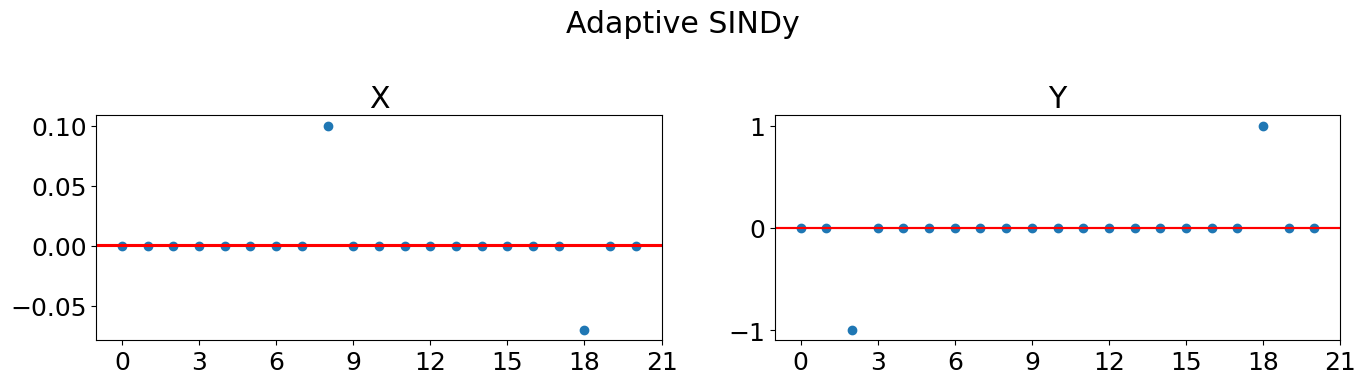

In [10]:
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('Adaptive SINDy')

ax[0].plot(COEFF_ADT [:, 0].detach().cpu().numpy(), 'o')
ax[0].set_title('X')
ax[0].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[0].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(COEFF_ADT [:, 1].detach().cpu().numpy(), 'o')
ax[1].set_title('Y')
ax[1].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[1].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()


In [11]:
print(COEFF_ADT)
print(SINE_ADT )
print(XSINE_ADT)
print(COSINE_ADT)
print(XCOSINE_ADT)
print(EXP_ADT)
print(XEXP_ADT)


tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -1.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.1000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0700,  1.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[0.2224, 0.6083],
        [0.0000, 0.4132]], device='cuda:0', requires

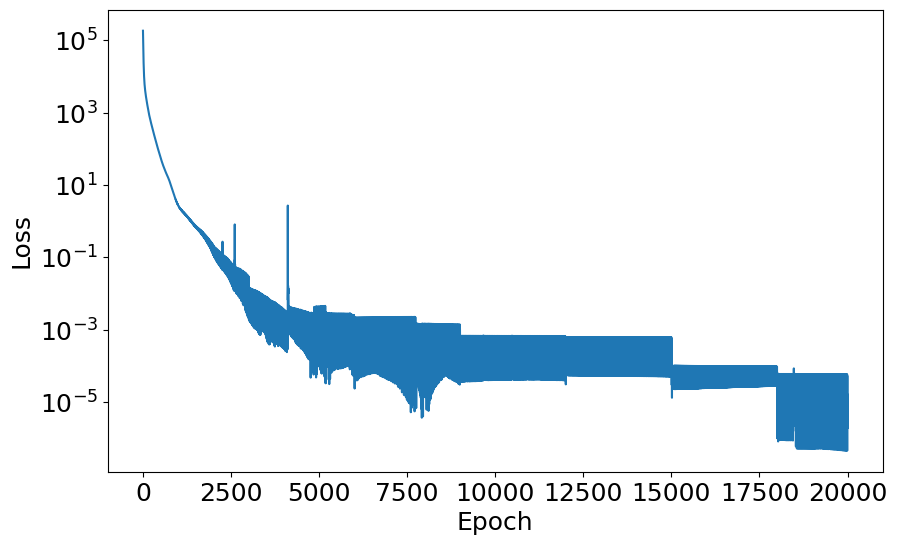

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(Loss_data.numpy())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(False)
plt.savefig('Loss_plot.jpeg', dpi = 1200)
plt.show()